<p style="font-weight:bold;font-size:200%"> Analysis </p>

- Author: Yichen
- Date: 20220911

In [155]:
import pandas as pd
import threading
import requests
import time
import os
import datetime
import re
import string
import random
import numpy as np
import seaborn as sns;sns.set_theme(color_codes=True)
import warnings
from web3 import Web3
from hexbytes import HexBytes

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from IPython.core.interactiveshell import InteractiveShell
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings("ignore")


RD = '/home/team_defi/02_rdata/'
WD = '/home/team_defi/03_wdata/'
RES = '/home/team_defi/04_result/'
InteractiveShell.ast_node_interactivity = 'all'

# Function

## Chain/DEX Info

In [7]:
def chain_info(chain):
    dexes = {'ethereum':['uniswapv3_ethereum', 'uniswapv2_ethereum', 'sushiswap_ethereum'],
             'binance':['pancake_binance', 'biswap_binance', 'apeswap_binance', 'babyswap_binance', 'jetswap_binance'],
             'avalanche':['traderjoe_avalanche', 'pangolin_avalanche'],
             'fantom':['spookyswap_fantom', 'spiritswap_fantom'],
             'polygon':['sushiswap_polygon', 'apeswap_polygon', 'jetswap_polygon']
            }
    
    dex = dexes[chain]
    return dex

## Token Price/Return

In [22]:
def token_dollar_price_date(contract, chain, date):
    
        contractAddress_lower = contract.lower()
        contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)
        
        priceUSD = 0
        dex_num = 0
        avg_priceUSD = 0

        for dex in chain_info(chain):
            lst = pd.read_csv(f'{WD}/dex_price/list_all/{dex}.csv')
            csv_info = lst.loc[((lst['contractAddress'] == contractAddress_lower)|
                                (lst['contractAddress'] == contractAddress_upper))]
            
            if csv_info['contractAddress'].values[0] == contractAddress_lower:
                contractAddress = contractAddress_lower
            else:
                contractAddress = contractAddress_upper

            status = csv_info['status'].values[0]
            dexn = csv_info['dex'].values[0]

            if status == 0: 
                continue
            elif dexn == 0:
                continue
            else:
                csv = pd.read_csv(f'{WD}dex_price/csv_all/{contractAddress}_{dex}.csv') 
                price_info = csv.loc[(pd.to_datetime(csv['date']) == pd.to_datetime(date))]
                
                if price_info.shape[0] != 0:
                    price = price_info['priceUSD'].values[0]
                    if price != 0:  
                        priceUSD += price
                        dex_num += 1

        if dex_num != 0: 
            return priceUSD/dex_num
        if dex_num == 0:
            return 0

In [21]:
def token_dollar_price(contract, chain, timestamp):
    
        contractAddress_lower = contract.lower()
        contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)

        date = timestamp.strftime('%Y-%m-%d')
        
        priceUSD = 0
        dex_num = 0
        avg_priceUSD = 0

        for dex in chain_info(chain):
            lst = pd.read_csv(f'{WD}/dex_price/list_all/{dex}.csv')
            csv_info = lst.loc[((lst['contractAddress'] == contractAddress_lower)|
                                (lst['contractAddress'] == contractAddress_upper))]
            
            if csv_info['contractAddress'].values[0] == contractAddress_lower:
                contractAddress = contractAddress_lower
            else:
                contractAddress = contractAddress_upper

            status = csv_info['status'].values[0]
            dexn = csv_info['dex'].values[0]

            if status == 0: 
                continue
            elif dexn == 0:
                continue
            else:
                csv = pd.read_csv(f'{WD}dex_price/csv_all/{contractAddress}_{dex}.csv') 
                price_info = csv.loc[(pd.to_datetime(csv['date']) > pd.to_datetime(timestamp) - datetime.timedelta(days=1))&
                                  (pd.to_datetime(csv['date']) < pd.to_datetime(timestamp))]
                
                if price_info.shape[0] != 0:
                    price = price_info['priceUSD'].values[0]
                    if price != 0:  
                        priceUSD += price
                        dex_num += 1

        if dex_num != 0: 
            return priceUSD/dex_num
        if dex_num == 0:
            return 0

In [68]:
def token_return(day, contract, chain, date):

    start_date = (pd.to_datetime(date) + datetime.timedelta(days=day-1)).strftime('%Y-%m-%d')
    end_date = (pd.to_datetime(date) + datetime.timedelta(days=day)).strftime('%Y-%m-%d')

    start_price = token_dollar_price_date(contract=contract, chain=chain, date=start_date)
    end_price = token_dollar_price_date(contract=contract, chain=chain, date=end_date)
    
    if (end_price == 0)|(start_price==0):
        return np.nan
    else:
        return np.log(end_price/start_price)

## Test

In [83]:
# token_dollar_price_date(contract = '0x86c86ffdc0482d8dd918fc657c3fc51c4a1e3e5c',
#                         chain = 'binance',
#                         date = '2022-03-31')
# token_dollar_price(contract = '0x86c86ffdc0482d8dd918fc657c3fc51c4a1e3e5c',
#                    chain = 'binance',
#                    timestamp = pd.to_datetime('2022-03-31 17:48:36'))
# '2022-03-31'
# (pd.to_datetime('2022-03-31') + datetime.timedelta(days=-1)).strftime('%Y-%m-%d')

# day = 1
# start_date = (pd.to_datetime('2022-03-31') + datetime.timedelta(days=day-1)).strftime('%Y-%m-%d')
# end_date = (pd.to_datetime('2022-03-31') + datetime.timedelta(days=day)).strftime('%Y-%m-%d')
# start_date
# end_date

# token_return(day=0,
#              contract='0x86c86ffdc0482d8dd918fc657c3fc51c4a1e3e5c',
#              chain='binance',
#              date='2022-03-31')

# token_dollar_price_date(contract='0x86c86ffdc0482d8dd918fc657c3fc51c4a1e3e5c',
#                         chain='binance',
#                         date='2022-04-01')

# day=1
# contract='0x86c86ffdc0482d8dd918fc657c3fc51c4a1e3e5c'
# chain='binance'
# date='2022-03-31'

# start_date = (pd.to_datetime(date) + datetime.timedelta(days=day-1)).strftime('%Y-%m-%d')
# end_date = (pd.to_datetime(date) + datetime.timedelta(days=day)).strftime('%Y-%m-%d')

# start_price = token_dollar_price_date(contract=contract, chain=chain, date=start_date)
# end_price = token_dollar_price_date(contract=contract, chain=chain, date=end_date)

# if (end_price == 0)|(start_price==0):
#     np.nan
# else:
#     np.log(end_price/start_price)
    
# start_date
# end_date
# start_price
# end_price

# Trading Day Return

## List

In [169]:
# lst = ['root', 'layer_one', 'whale']
# dfs = []
# for csv in lst:
#     df = pd.read_csv(f'{RES}/transaction/{csv}.csv')
#     if csv == 'root': 
#         df = df.drop_duplicates(['contractAddress', 'chain']).loc[:, ['contractAddress', 'chain']]
#     else:
#         df = df.drop_duplicates(['insider_contractAddress', 'chain']).loc[:, ['insider_contractAddress', 'chain']]
#         df.rename(columns={'insider_contractAddress':'contractAddress'}, inplace=True)
#     dfs.append(df)
    
# dfs = pd.concat(dfs)
# dfs.drop_duplicates(['contractAddress', 'chain'], inplace=True)
# dfs['status'] = -1
# dfs.to_csv(f'{WD}token_ret/lst/list.csv', index=False)
# dfs

,contractAddress,chain,status
0,0x24e89bdf2f65326b94e36978a7edeac63623dafa,ethereum,-1
1,0x4ffcad848248d4931374336fcaccf263638413ae,ethereum,-1
2,0x6339bd92eaa3cb8e629b06449e08b90581a33cea,ethereum,-1
6,0x284b19a5fa65f706422c0c86566e407b0e70e537,ethereum,-1
7,0xab68e9f518620cc76d28fa08f42d4f2939d40f02,ethereum,-1
...,...,...,...
6147,0x073F39ce7a0DE99992FD4c4693FD1895Fe7a4ADF,avalanche,-1
6166,0x04545B7972fd1A1E65a35226088DC37fAF246Fe5,avalanche,-1
6171,0x60fD06537A41c1c5371950431FB6162f096612A7,avalanche,-1
6190,0xE6780CC551DF332ce7a05A6F59fB2A26e4b0f9aD,avalanche,-1


## Match

In [200]:
dfs = pd.read_csv(f'{WD}token_ret/lst/list.csv')
total = dfs.shape[0]
done = dfs.loc[dfs['status'] != -1].shape[0]

for idx, row in dfs.loc[dfs['status'] == -1].iterrows():
    try:
        done += 1
        contract = row['contractAddress']
        chain = row['chain']

        contractAddress_lower = contract.lower()
        contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)

        dex_num = 0

        panel = []
        for dex in chain_info(chain):
            lst = pd.read_csv(f'{WD}/dex_price/list_all/{dex}.csv')
            csv_info = lst.loc[((lst['contractAddress'] == contractAddress_lower)|
                                (lst['contractAddress'] == contractAddress_upper))]

            if csv_info['contractAddress'].values[0] == contractAddress_lower:
                contractAddress = contractAddress_lower
            else:
                contractAddress = contractAddress_upper

            status = csv_info['status'].values[0]
            dexn = csv_info['dex'].values[0]

            if status == 0: 
                continue
            elif dexn == 0:
                continue
            else:
                csv = pd.read_csv(f'{WD}dex_price/csv_all/{contractAddress}_{dex}.csv') 
                csv = csv.loc[:, ['priceUSD', 'date']]
                panel.append(csv)
                dex_num += 1

        if dex_num != 0:
            panel = pd.concat(panel)
            panel = panel.loc[panel['priceUSD']!=0]
            if panel.shape[0] == 0:
                dfs.loc[(dfs['contractAddress'] == contract)&(dfs['chain']==chain), 'status'] = 0
                dfs.to_csv(f'{WD}token_ret/lst/list.csv', index=False)
                print(f'{contract} Zero Price Info, {done}/{total}')
                continue


            start_date = panel['date'].min()
            end_date = panel['date'].max()
            avg = panel.groupby('date')['priceUSD'].mean().reset_index()
            avg['contractAddress'] = contract
            avg['chain'] = chain
            avg['date'] = pd.to_datetime(avg['date'])
            avg.to_csv(f'{WD}token_ret/csv/{contract}_{chain}_avg.csv', index=False)

            ret = pd.DataFrame({'date':pd.date_range(start = start_date, end=end_date)})
            ret['contractAddress'] = contract
            ret['chain'] = chain

            for day in range(-5, 6):
                ret[f'ret_{str(day)}'] = np.nan

            for idx_ret, row_ret in ret.iterrows():
                date = row_ret['date']
                for day in range(-5, 6):

                    start_date = (pd.to_datetime(date) + datetime.timedelta(days=day-1)).strftime('%Y-%m-%d')
                    end_date = (pd.to_datetime(date) + datetime.timedelta(days=day)).strftime('%Y-%m-%d')

                    start_info = avg.loc[avg['date'] == start_date, 'priceUSD'].values
                    end_info = avg.loc[avg['date'] == end_date, 'priceUSD'].values

                    if ((len(start_info)==0)|(len(end_info)==0)):
                        ret.loc[ret['date'] == date, f'ret_{str(day)}'] = np.nan
                    else:
                        ret.loc[ret['date'] == date, f'ret_{str(day)}'] = np.log(end_info[0]/start_info[0])

                if len(avg.loc[avg['date'] == date, 'priceUSD'].values) == 0:  
                    ret.loc[ret['date'] == date, 'priceUSD'] = np.nan
                else:
                    ret.loc[ret['date'] == date, 'priceUSD'] = avg.loc[avg['date'] == date, 'priceUSD'].values[0]
        else:
            dfs.loc[(dfs['contractAddress'] == contract)&(dfs['chain']==chain), 'status'] = 0
            dfs.to_csv(f'{WD}token_ret/lst/list.csv', index=False)
            print(f'{contract} Zero DEX Info, {done}/{total}')
            continue

        ret.to_csv(f'{WD}token_ret/csv/{contract}_{chain}_ret.csv', index=False)
        dfs.loc[(dfs['contractAddress'] == contract)&(dfs['chain']==chain), 'status'] = 1
        dfs.to_csv(f'{WD}token_ret/lst/list.csv', index=False)
        print(f'{contract} Done, {done}/{total}')
        
    except Exception as e:
        print(f'{contract} Error: {e}, {done}/{total}')

0xD4B14270f55317CCC75522d900487F8426Bf072e Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/dex_price/csv_all/0xD4B14270f55317CCC75522d900487F8426Bf072e_uniswapv3_ethereum.csv', 1107/1580
0x26768Ca0FB372879fB18B96fD6575D8262f7F35b Zero Price Info, 1108/1580
0x6D1fBC1c0Bf1623DbdBc2d48fa47B8BD34Cb62a2 Zero Price Info, 1109/1580
0xd029ddCE2c11c560f9B07c1B0a8327ADc988Aa87 Zero Price Info, 1110/1580
0x656b23aA269871eDA54DD9eF1063D456515850d5 Zero Price Info, 1111/1580
0x3Ba4f251b27542858eD448E17f53f9d77D07b01e Zero Price Info, 1112/1580
0x82919Ca4De7A039E7d40D8Eb75b784EB80ba638a Done, 1113/1580
0x22c5543d1a35178cB03b33f929A959145E538532 Done, 1114/1580
0x498084f26DDDD677a8117C83084C3EA637f5a50f Done, 1115/1580
0x63C62103f9B7E8e43A351Cd64B022644DF492Bf3 Zero Price Info, 1116/1580
0x46FE865B8bE7efE90d8eF65cbFf7a67022CEF2a2 Zero Price Info, 1117/1580
0x414100f6fE89c0c18660df1fa201E531912d6BE1 Done, 1118/1580
0x6Fea518B59278f60892dbCf336f2E17dac651DeC Done, 1119/1580
0x7324

## Correction: Nan

In [210]:
dfs['status'].value_counts()
dfs.loc[dfs['status'] == -1, 'status'] = 0
dfs['status'].value_counts()
dfs.to_csv(f'{WD}token_ret/lst/list.csv', index=False)

## Panel

In [212]:
dfs = pd.read_csv(f'{WD}token_ret/lst/list.csv')
panel = []
for idx, row in dfs.loc[dfs['status'] == 1].iterrows():
    contract = row['contractAddress']
    chain = row['chain']
    
    df = pd.read_csv(f'{WD}token_ret/csv/{contract}_{chain}_ret.csv')
    panel.append(df)

panel = pd.concat(panel)
panel.to_csv(f'{WD}token_ret/lst/panel_raw.csv', index=False)

## Sample Check

In [214]:
panel.sample(3)

,date,contractAddress,chain,ret_-5,ret_-4,ret_-3,ret_-2,ret_-1,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,priceUSD
141,2021-09-12,0x9e547061a345015869d26c7b6ee4ab5b63424441,ethereum,-0.131056,0.091307,-0.118645,-0.004026,0.017635,0.057769,-0.020800,0.046312,0.023731,-0.140550,-0.039343,10.285415
40,2022-04-05,0x8b660da0f7c74d2464a19a3d67e202dcb6bcfdaf,ethereum,NaN,0.056291,0.000392,-0.197587,-0.046936,-0.105005,-0.109357,-0.043594,-0.019017,-0.074021,-0.010199,0.001739
333,2022-03-25,0xb42e1c3902b85b410334f5fff79cdc51fbee6950,binance,-0.024969,-0.166698,0.008437,-0.025717,-0.008324,0.020511,0.057840,0.040888,0.025745,0.019833,0.090779,1.385271


In [255]:
contract = '0x3d3d5ac7590201cec07e7088145d17da535645e3'
chain = 'ethereum'

contractAddress_lower = contract.lower()
contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)

dex_num = 0

panel = []
for dex in chain_info(chain):
    dex
    lst = pd.read_csv(f'{WD}/dex_price/list_all/{dex}.csv')
    csv_info = lst.loc[((lst['contractAddress'] == contractAddress_lower)|
                        (lst['contractAddress'] == contractAddress_upper))]
    if csv_info['contractAddress'].values[0] == contractAddress_lower:
        contractAddress = contractAddress_lower
    else:
        contractAddress = contractAddress_upper

    status = csv_info['status'].values[0]
    dexn = csv_info['dex'].values[0]

    if status == 0: 
        continue
    elif dexn == 0:
        continue
    else:
        csv = pd.read_csv(f'{WD}dex_price/csv_all/{contractAddress}_{dex}.csv') 
        csv = csv.loc[:, ['priceUSD', 'date']]
        panel.append(csv)
        dex_num += 1
panel = pd.concat(panel)
panel = panel.loc[panel['priceUSD']!=0]
panel
panel.loc[panel['date'] == '2022-06-06']

'uniswapv3_ethereum'

'uniswapv2_ethereum'

'sushiswap_ethereum'

,priceUSD,date
0,3.271300e-12,2022-04-04
1,2.291400e-12,2022-04-05
2,2.130400e-12,2022-04-06
3,2.598500e-12,2022-04-07
4,2.119100e-12,2022-04-08
5,2.179400e-12,2022-04-09
6,1.986100e-12,2022-04-10
7,1.518300e-12,2022-04-11
8,5.844000e-13,2022-04-12
9,5.187000e-13,2022-04-13


,priceUSD,date


# Variables

## List Info

In [228]:
df = pd.read_csv(f'{WD}token_ret/lst/panel_raw.csv')
lsts = ['root', 'layer_one', 'whale']

for lst in lsts:
    df[lst] = False
    dfs = pd.read_csv(f'{RES}/transaction/{lst}.csv')
    if lst == 'root': 
        dfs = dfs.drop_duplicates(['contractAddress', 'chain']).loc[:, ['contractAddress', 'chain']]
    else:
        dfs = dfs.drop_duplicates(['insider_contractAddress', 'chain']).loc[:, ['insider_contractAddress', 'chain']]
        dfs.rename(columns={'insider_contractAddress':'contractAddress'}, inplace=True)
        
    for idx, row in dfs.iterrows():
        contractAddress = row['contractAddress']
        chain = row['chain']
        df.loc[(df['contractAddress'] == contractAddress)&(df['chain'] == chain), lst] = True
df.to_csv(f'{WD}token_ret/lst/panel_list.csv', index=False)

## Insider Trading Info

In [ ]:
df = pd.read_csv(f'{WD}token_ret/lst/panel_list.csv')
lsts = ['root', 'layer_one', 'whale']
df['insider_trading'] = False
df['insider_buy'] = False
df['insider_sell'] = False

for lst in lsts:
    done = 0
    dfs = pd.read_csv(f'{RES}/transaction/{lst}.csv')
    total = dfs.shape[0]
    dfs['timestamp'] = pd.to_datetime(dfs['timestamp'])
    dfs['date'] = dfs['timestamp'].dt.strftime('%Y-%m-%d')
    
    if lst != 'root': dfs.rename(columns={'insider_contractAddress':'contractAddress'}, inplace=True)
        
    for idx, row in dfs.iterrows():
        done += 1
        chain = row['chain']
        contractAddress = row['contractAddress']
        date = row['date']
        buy = row['buy']
        
        if buy != 0:
            df.loc[(df['contractAddress'] == contractAddress)&(df['date'] == date)&(df['chain'] == chain), 'insider_trading'] = True
        
        if buy > 0:
            df.loc[(df['contractAddress'] == contractAddress)&(df['date'] == date)&(df['chain'] == chain), 'insider_buy'] = True
            
        if buy < 0:
            df.loc[(df['contractAddress'] == contractAddress)&(df['date'] == date)&(df['chain'] == chain), 'insider_sell'] = True
            
        print(f'{lst}: {done}/{total}')

root: 1/15470
root: 2/15470
root: 3/15470
root: 4/15470
root: 5/15470
root: 6/15470
root: 7/15470
root: 8/15470
root: 9/15470
root: 10/15470
root: 11/15470
root: 12/15470
root: 13/15470
root: 14/15470
root: 15/15470
root: 16/15470
root: 17/15470
root: 18/15470
root: 19/15470
root: 20/15470
root: 21/15470
root: 22/15470
root: 23/15470
root: 24/15470
root: 25/15470
root: 26/15470
root: 27/15470
root: 28/15470
root: 29/15470
root: 30/15470
root: 31/15470
root: 32/15470
root: 33/15470
root: 34/15470
root: 35/15470
root: 36/15470
root: 37/15470
root: 38/15470
root: 39/15470
root: 40/15470
root: 41/15470
root: 42/15470
root: 43/15470
root: 44/15470
root: 45/15470
root: 46/15470
root: 47/15470
root: 48/15470
root: 49/15470
root: 50/15470
root: 51/15470
root: 52/15470
root: 53/15470
root: 54/15470
root: 55/15470
root: 56/15470
root: 57/15470
root: 58/15470
root: 59/15470
root: 60/15470
root: 61/15470
root: 62/15470
root: 63/15470
root: 64/15470
root: 65/15470
root: 66/15470
root: 67/15470
root

In [252]:
df.sample(3)
df.to_csv(f'{WD}token_ret/lst/panel_insider.csv', index=False)

,date,contractAddress,chain,ret_-5,ret_-4,ret_-3,ret_-2,ret_-1,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,priceUSD,root,layer_one,whale,insider_trading,insider_buy,insider_sell
105815,2022-05-30,0x3d3d5ac7590201cec07e7088145d17da535645e3,ethereum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False,False
3628,2021-09-11,0xc944e90c64b2c07662a292be6244bdf05cda44a7,ethereum,0.037183,-0.245512,0.002839,0.041627,-0.073211,0.076147,0.063823,-0.096964,0.019948,0.053181,-0.048670,0.869054,True,False,False,False,False,False
55532,2021-12-15,0xd44fd09d74cd13838f137b590497595d6b3feea4,binance,-0.213593,0.043456,0.113553,-0.251955,-0.174707,-0.004389,-0.253106,-0.119669,0.073889,-0.059916,0.016619,2.270153,True,False,False,False,False,False


# Cummulative Return and Winning Return

In [4]:
df = pd.read_csv(f'{WD}token_ret/lst/panel_insider.csv')

df['cumret_-5'] = df['ret_-5']
df['cumret_-4'] = df['ret_-5'] + df['ret_-4']
df['cumret_-3'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3']
df['cumret_-2'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2']
df['cumret_-1'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1']
df['cumret_0'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0']
df['cumret_1'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1']
df['cumret_2'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1'] + df['ret_2']
df['cumret_3'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1'] + df['ret_2'] + df['ret_3']
df['cumret_4'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4']
df['cumret_5'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4'] + df['ret_5']

df['winning_ret_1'] = df['ret_1']
df['winning_ret_2'] = df['ret_1'] + df['ret_2']
df['winning_ret_3'] = df['ret_1'] + df['ret_2'] + df['ret_3']
df['winning_ret_4'] = df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4']
df['winning_ret_5'] = df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4'] + df['ret_5']

df.to_csv(f'{WD}token_ret/lst/panel_return.csv', index=False)

In [5]:
df.sample(3)
df.shape[0]

,date,contractAddress,chain,ret_-5,ret_-4,ret_-3,ret_-2,ret_-1,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,priceUSD,root,layer_one,whale,insider_trading,insider_buy,insider_sell,cumret_-5,cumret_-4,cumret_-3,cumret_-2,cumret_-1,cumret_0,cumret_1,cumret_2,cumret_3,cumret_4,cumret_5,winning_ret_1,winning_ret_2,winning_ret_3,winning_ret_4,winning_ret_5
78613,2022-04-11,0x64815277c6caf24c1c2b55b11c78ef393237455c,binance,-0.056318,0.018329,-0.141307,0.042887,0.009142,-0.081035,0.038522,0.018850,-0.016551,0.539994,-0.349590,0.003434,True,False,False,False,False,False,-0.056318,-0.037990,-0.179297,-0.136409,-0.127267,-0.208301,-0.169780,-0.150929,-0.167481,0.372514,0.022924,0.038522,0.057372,0.040821,0.580815,0.231225
134104,2022-03-03,0xA9ECF878d73265b9773CD298eC3aFe40C9D13fE8,binance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114619,2022-08-19,0x477bc8d23c634c154061869478bce96be6045d12,binance,-0.078792,0.019957,-0.009611,-0.060841,-0.085657,-0.107610,-0.000445,0.064211,-0.011033,-0.004356,-0.015779,2.069462,False,True,False,False,False,False,-0.078792,-0.058835,-0.068446,-0.129287,-0.214945,-0.322554,-0.322999,-0.258788,-0.269822,-0.274177,-0.289957,-0.000445,0.063766,0.052733,0.048377,0.032597


135151

# Events

## Range

In [41]:
df = pd.read_csv(f'{WD}token_ret/lst/panel_return.csv')
lst = pd.read_csv(f'{WD}tweet_all/list/list.csv')
total = df.drop_duplicates('contractAddress').shape[0]
done = 0

event_info = [f'event_{i}' for i in range(0, 4)]
df['twitter'] = 0

for i in event_info:
    df[i] = 0
    
for idx, row in df.drop_duplicates('contractAddress').iterrows():
    try:
        done += 1
        contractAddress = row['contractAddress']

        status = lst.loc[lst['contractAddress'] == contractAddress, 'twitter'].values[0]
        df.loc[df['contractAddress'] == contractAddress, 'twitter'] = status

        if status == 0: 
            print(f'{contractAddress} have no twitter info. {done}/{total}')
            continue

        dft = pd.read_csv(f'{WD}tweet_all/csv/{contractAddress}_tweets.csv')
        dft.dropna(inplace=True)
        dft['date'] = pd.to_datetime(dft['timestamp']).dt.strftime('%Y-%m-%d')

        dft['text'] = dft['text'].apply(lambda x: x.lower())
        dft = dft.loc[[True if re.search('listing', i) else False for i in dft['text']]]
        events = dft['date'].unique()

        for event in events:
            for day in [0, 1, 2, 3]:
                df.loc[(df['contractAddress'] == contractAddress)&
                       (pd.to_datetime(df['date']) <= pd.to_datetime(event) + datetime.timedelta(days=day))&
                       (pd.to_datetime(df['date']) >= pd.to_datetime(event) - datetime.timedelta(days=day)), f'event_{day}'] = 1

        print(f'{contractAddress} done. {done}/{total}')
    except Exception as e:
        print(f'{contractAddress} Error: {e}')
        dft

0x24e89bdf2f65326b94e36978a7edeac63623dafa done. 1/1226
0x4691937a7508860f876c9c0a2a617e7d9e945d4b done. 2/1226
0xeb953eda0dc65e3246f43dc8fa13f35623bdd5ed done. 3/1226
0xabe580e7ee158da464b51ee1a83ac0289622e6be done. 4/1226
0xc18360217d8f7ab5e7c516566761ea12ce7f9d72 done. 5/1226
0xeff3f1b9400d6d0f1e8805bdde592f61535f5ecd done. 6/1226
0xa71d0588eaf47f12b13cf8ec750430d21df04974 done. 7/1226
0x2a3bff78b79a009976eea096a51a948a3dc00e34 done. 8/1226
0x3873965e73d9a21f88e645ce40b7db187fde4931 done. 9/1226
0xc944e90c64b2c07662a292be6244bdf05cda44a7 done. 10/1226
0x8c6fa66c21ae3fc435790e451946a9ea82e6e523 done. 11/1226
0x1c7e83f8c581a967940dbfa7984744646ae46b29 done. 12/1226
0xb6ff96b8a8d214544ca0dbc9b33f7ad6503efd32 done. 13/1226
0x506d62bf7d8a8f444f13533081dc03470483f4ea have no twitter info. 14/1226
0x18084be33d80c3fdf6e7e7deab4a4e5e26657331 done. 15/1226
0x77d1b367221a5864af03d7a9e4e6ae2e6cd2a0ae done. 16/1226
0x1f9840a85d5af5bf1d1762f925bdaddc4201f984 done. 17/1226
0x834806a97938ae7270d3df

,timestamp,text,date


0xcf9eba19063490d937e8638b9e298b1889474565 done. 70/1226
0xd78dd8463058c7297d8f8ca08bcccb817e2593fb done. 71/1226
0x4e3c8ffa83509e6920df798c35afbe3df7ae91de done. 72/1226
0xa33cf97d12f5e014958c99ac47746cf5aa5b6ab2 done. 73/1226
0xd73c1217243eadb3df485cb414b9c015b1aabfbc have no twitter info. 74/1226
0x3c4733464e5e8bf570d2a6f2c05f35e3d4def2cc done. 75/1226
0xe838416a29c87551cca4f882a7257ac33a831f96 done. 76/1226
0x39243cc473147469d3149fa267de26cbf64a05f0 done. 77/1226
0x38b3e70342ff7cb68a3a1461b95946f4bc3d9e0c done. 78/1226
0xa2f2138915251b5357630d1c1dfbf72ba2887f94 done. 79/1226
0x52fa95db98a9b915234fc2ee9fb6972a8861f51a done. 80/1226
0x430c7b8e890f46571fe5fcad5e88e0499ea99dd5 done. 81/1226
0xb52db7659a5ec66c0adffd8253cf7fb3be1b813d done. 82/1226
0x943ac65403a38ccfc06414e01edcaf838169e928 done. 83/1226
0x4be6ee90e77b1b28b24c89b723cc4ec4552f48b8 done. 84/1226
0x7c42c4c5434b4a7ad66661b0dde4c27db65a18ff done. 85/1226
0x8eab9289c569844361cc7511ddd3c98d7609042b have no twitter info. 86/1226

,timestamp,text,date
569,2021-09-22 14:15:54+00:00,rt @healthy_pockets: enhorabuena chicos por el listing! 😁\n\n@scandefi fue listada ayer en @coin...,2021-09-22
574,2021-09-21 18:02:10+00:00,"rt @cmclistings: 🆕 new coinmarketcap listing: $scan \n🐦 twitter: @scandefi\n📋 contract: bsc, bnb...",2021-09-21
690,2021-08-25 16:59:26+00:00,rt @piqueressamuel: @coinlistings @scandefi this a great project for criptobelievers,2021-08-25
695,2021-08-25 07:29:16+00:00,"rt @coinlistings: 🆕 new coingecko listing: $scan \n🐦 twitter: @scandefi\n📋 contract: bsc, bnb\nh...",2021-08-25


0xa6c897caaca3db7fd6e2d2ce1a00744f40ab87bb done. 335/1226
0x7cfffc84b2ae51bbcb6fdf90bed564a1543598c1 have no twitter info. 336/1226
0xbfdfb624fdeb97e30497b9c18774117357d9ec5c have no twitter info. 337/1226
0x0c14f1681f0396188c59c5e610e8609d22c469bb done. 338/1226
0x0615dbba33fe61a31c7ed131bda6655ed76748b1 done. 339/1226
0xd9aa5aad0bc626bb947f6538c3a2df0a72e0aa68 done. 340/1226
0xb2f66d035022b41b620fa78e2890e8e8855bf5bd done. 341/1226
0xbd65a197408230247f05247a71d1a9aea9db0c3c done. 342/1226
0x55e00121241d6870324a8e6dffaabbe2e0359863 have no twitter info. 343/1226
0x20ad73b56168684c30403355e9b564f699b71850 done. 344/1226
0x159735b6384a1da94a6755277142bd01ae5fe065 done. 345/1226
0xea6c643b02ead1e42813771826e64a70a973f3e9 done. 346/1226
0x02aa5cdf7350924de2fa88041da99993cb021219 done. 347/1226
0x55d398326f99059ff775485246999027b3197955 have no twitter info. 348/1226
0xd64f7b8962ede286ac66e290b5d3e5f8f4e019fb done. 349/1226
0x6679eb24f59dfe111864aec72b443d1da666b360 done. 350/1226
0x4a9b81

,timestamp,text,date


0x08c6c4bef430454e4efc02981fe5da8dcd41c96f have no twitter info. 473/1226
0xbc009a481d2bce34a23e56cfa2369250e963e3e7 done. 474/1226
0xe90334c19c798c3a18d81b8cd16594247d5b19dd done. 475/1226
0xe8d1803b6878ba534f11fcb29495cf0d19487d61 done. 476/1226
0xc97d59d5c2387f5ac09520ef47663161671f4c0a done. 477/1226
0x330a769cf94bed767e07e7b1c597406fe09d67f0 done. 478/1226
0x78c6e90afa87e2c97cac1a07652aa0998c6c9078 done. 479/1226
0x5ac31c662af6008a113e0ebfed4ef8d889a4cafe done. 480/1226
0xaf44400a99a9693bf3c2e89b02652babacc5cdb9 have no twitter info. 481/1226
0x15a20d7946941f446ddf9e5f64e2f65720d4bb49 done. 482/1226
0x03363a7314f0f1ced76892348909f36d11c475de done. 483/1226
0x3bff6c8ac760f636e50227aad0889fa2c80dc78c done. 484/1226
0xc9e91a021406eb98c3176a677247271ea6d3c7d4 done. 485/1226
0x533a4a72e203c5b15797d2f1059223c6234afa73 done. 486/1226
0xfc206f429d55c71cb7294eff40c6adb20dc21508 done. 487/1226
0x4734367341a4772473b92325c9cf56ab52b88981 done. 488/1226
0xaf676214fa60cafa3d0c3e7b13d3bb3ca292ee

,timestamp,text,date
35,2021-10-11 15:30:24+00:00,another exciting listing news coming up! stay tuned!,2021-10-11
62,2021-08-20 19:04:33+00:00,nether achieves another important milestone. we were recently featured in @coinmarketcap\nmagazi...,2021-08-20
77,2021-08-06 09:40:28+00:00,🏆🏆 latoken listing competition results 🏆🏆\n\nwe are pleased to announce that nether has won the ...,2021-08-06
138,2021-06-23 10:28:02+00:00,"rt @crypto: new: dubai exchange gets its first crypto listing, and prices jump https://t.co/glzy...",2021-06-23


0x7841798f6f240bcff9557044722feb31f93dfa81 done. 566/1226
0x71fac45700585555c936c2061fc1fd42b86f4d91 done. 567/1226
0x270a84dcdfb305cc68be21e767ef11aac5dc5cf0 done. 568/1226
0x7dff85eeb321957a429fa220ec2664774240b766 done. 569/1226
0xa5fbc3520dd4bb85fcd175e1e3b994546a2c1ee8 done. 570/1226
0x12bb890508c125661e03b09ec06e404bc9289040 done. 571/1226
0x147d7d47c9340253dc5adf0574e7bc4b05630aed done. 572/1226
0x6ba7a8f9063c712c1c8cabc776b1da7126805f3b have no twitter info. 573/1226
0x7ae5709c585ccfb3e61ff312ec632c21a5f03f70 done. 574/1226
0x778682c19797d985c595429fbc51d67736013a86 done. 575/1226
0x722abb6b45df70bba7333af705d86be90c985be0 done. 576/1226
0x234a97aa8c9b64b69c8344bf2c59dc3a5b1ff2ce done. 577/1226
0x17179f506b89d80291b581f200f34b17ff172cd3 have no twitter info. 578/1226
0xac019ee3863984ea66ab357a491d37fb2c9c6f17 done. 579/1226
0xe4f898c396c0b9e57a882ddf883a0e8733e757d1 have no twitter info. 580/1226
0xbc23833d965632cec84bf98181cb84c31bbdfa94 done. 581/1226
0x2e86a090050ea7b36d5596

,timestamp,text,date
103,2022-04-07 19:58:07+00:00,thanks for listing us 😇 https://t.co/kg5kko6z7d,2022-04-07
238,2022-01-27 15:37:11+00:00,"#cardano and #ergo community-- neta will be listed on ergodex tomorrow, january 28th, 2022 😇\n\n...",2022-01-27
317,2021-11-29 22:41:56+00:00,"rt @woofbowwow2: $erg mining emissions being tuned down\n\n@ergodex listing $eth, $ada, and #evm...",2021-11-29


0x321e7092a180bb43555132ec53aaa65a5bf84251 done. 738/1226
0x61ecd63e42c27415696e10864d70ecea4aa11289 done. 739/1226
0x55ff87a41e4438e37bc53242a92689e4423a5874 have no twitter info. 740/1226
0xdd453dbd253fa4e5e745047d93667ce9da93bbcf have no twitter info. 741/1226
0x60781c2586d68229fde47564546784ab3faca982 done. 742/1226
0x3aca5545e76746a3fe13ea66b24bc0ebcc51e6b4 have no twitter info. 743/1226
0xf03ab1c1fccbcb470c47f3eb642db31c30d240a4 done. 744/1226
0x7086e045b78e1e72f741f25231c08d238812cf8a done. 745/1226
0xd6070ae98b8069de6b494332d1a1a81b6179d960 done. 746/1226
0x44d09156c7b4acf0c64459fbcced7613f5519918 done. 747/1226
0xd0f05d3d4e4d1243ac826d8c6171180c58eaa9bc done. 748/1226
0x71159f1a426c4b2b4df691d4ed215f6a2a32dd54 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x71159f1a426c4b2b4df691d4ed215f6a2a32dd54_tweets.csv'


,timestamp,text,date
129,2021-06-10 10:13:26+00:00,detailed tokenomics of the upcoming dex listing event of https://t.co/gexh0sobvi - project of va...,2021-06-10
130,2021-06-08 09:13:22+00:00,the listing of https://t.co/gexh0sobvi is postponed to june 24th\n\nvalue network qtum global ha...,2021-06-08
136,2021-05-31 00:41:25+00:00,"the holders of $vntw will get https://t.co/gexh0sobvi tokens with 1to1 ratio, vested for 1 year....",2021-05-31
150,2021-05-20 08:35:43+00:00,listing of https://t.co/gexh0sobvi will take place on june 10th on pancakeswap\n\nthe first proj...,2021-05-20
195,2021-04-25 14:31:12+00:00,a bunch of new listings\n\nhttps://t.co/fdxegpalzo\n\nhttps://t.co/mf8jyfhrlw\n\nhttps://t.co/le...,2021-04-25
208,2021-04-20 11:51:49+00:00,5th may on russian community meetup new project that is disrupting corporate service providers i...,2021-04-20
256,2020-12-26 01:44:44+00:00,sunday - 2nd ama session\n\ndecember 29th - mainnet token deploy\n\njanuary 5th - listing uniswa...,2020-12-26


0xd3361608394f3832261ca62ddd7966a7a3ee6209 done. 750/1226
0xe7ae6d0c56cacaf007b7e4d312f9af686a9e9a04 done. 751/1226
0x87de305311d5788e8da38d19bb427645b09cb4e5 done. 752/1226
0xa420dd089a33d3751e8750f0b3554c72761dc83e done. 753/1226
0xb2f8a70b09db0f7795a5f079b5021eb84aa59e28 have no twitter info. 754/1226
0x49db9e9a734e1210825611b2b971eae39389365b done. 755/1226
0x9e547061a345015869d26c7b6ee4ab5b63424441 done. 756/1226
0xbe127c98e91e43e7f69d3185e500c9f266ef1513 done. 757/1226
0x1cb04c35e818087fd4b537a18d74c2e4f196016d done. 758/1226
0x3d3d5ac7590201cec07e7088145d17da535645e3 have no twitter info. 759/1226
0xc8d3dcb63c38607cb0c9d3f55e8ecce628a01c36 done. 760/1226
0x702e4bf464cea5576f7b7cf1f2eb5192b907c910 have no twitter info. 761/1226
0x41045282901e90bda7578d628e479e5421d1cdd5 done. 762/1226
0x9c2dc0c3cc2badde84b0025cf4df1c5af288d835 done. 763/1226
0xadffd831285d0ce26fbe98d2a26c0c9f65693c0a done. 764/1226
0x6069c9223e8a5da1ec49ac5525d4bb757af72cd8 done. 765/1226
0x5d8038644608d1f849ed2c

,timestamp,text,date


0x42707E709Daee0EB5273B79AAd755C5f18309AdF have no twitter info. 925/1226
0x7747F18F8C558644d257f9C16103f601215E6Fe4 done. 926/1226
0xBAf492dB87155Cf15bd1475395635d043c2683Ad done. 927/1226
0xdCc6cAdA462B820E883658124644E58F7283765e done. 928/1226
0x62665756c8B01e8568bddD9F63CfC5C11073f04A done. 929/1226
0x3E62CcD238b2921E9226984F3def2f9A8b1EB775 done. 930/1226
0x7ddaec67bE2fB61C9B79d3fC7307F7A58324CC25 done. 931/1226
0x661234dF253667817E0F19e56fcF6A1cCad5b78A done. 932/1226
0x007f9FC30540cD396Af627E6B93E4d742E724898 done. 933/1226
0x80C258162c856df06AdfdB1b0bCa209d0bF767D9 done. 934/1226
0x9F7c7EDCE870bBFbff46466E9979F8c6D73474ba have no twitter info. 935/1226
0x9a772c55a348B970488DF0F454f23ef04bb5fEeb done. 936/1226
0x08cce68CfE23BbF13E3151c2a43dCc02623710d6 done. 937/1226
0xCE9D71Bd1ED93dD0b12D2A2A17bA884abae7FAD8 done. 938/1226
0x96b21b6eC0e6d4524D7827b03B6D4425eE1ff886 done. 939/1226
0x7F66Ef4bE2c128f121ca776888e6142EC0F3BD75 done. 940/1226
0x8d36f657D51B385af0e660dEfBc92de2902DB1

,timestamp,text,date


0xfDfEB2E1592bF2566e8410C6F9963ef43705B634 done. 965/1226
0x2B581A743d8c74722F8987E3D28087397ca69669 have no twitter info. 966/1226
0x6B2791F9D332427109C6Dc027aa831C02D42ad42 done. 967/1226
0x218C5ca2dFC0BB38eFA01691dee3519aE206A914 have no twitter info. 968/1226
0xb171dae5e6dc6c2EfcdAe1C15f8d1e2805199d06 done. 969/1226
0x12457ef8236Ff3f2D21f9af23c2c09E6A0e68947 have no twitter info. 970/1226
0x1E944eFFbB0674584DCC6913253D1F1b9E031E1f have no twitter info. 971/1226
0x5df87BF622D9C7d8CFdDD7edE78c2C90F98Ae933 have no twitter info. 972/1226
0x0de3539f225E3431D6a7bbd3495cC2CAF19b334C done. 973/1226
0x262f672b99E0EB3C01dB21c23e8b1e368ef88F4c done. 974/1226
0x017413445e227106FD198cb64547C615f4f13522 have no twitter info. 975/1226
0x255729c36A0BF1c5F1fECee0abEC6e920bB348b2 done. 976/1226
0x17e37476313D6E5f152D6De9e9f4fEd7DcBbCADa done. 977/1226
0x1e3F2e311845952531fEB212Da2A2F304e1018E0 have no twitter info. 978/1226
0x10729A14b7f3aBDf098077297001a6C7B41Fb51b have no twitter info. 979/1226
0x

,timestamp,text,date
24,2022-07-16 17:23:48+00:00,we are trending at https://t.co/lkpiixtylf events.\n\nhttps://t.co/vf16i5moad\n\n#ricnatum #rcnt...,2022-07-16
25,2022-07-16 09:08:15+00:00,we are excited to announce the trading opening of ricnatum (rcnt). \n\nthe trading of this proje...,2022-07-16
26,2022-07-14 07:48:36+00:00,"nexdax is waiting for us. we are ready, how about you!\n\nricnatum will be listed on the nexdax ...",2022-07-14
54,2022-02-11 13:33:09+00:00,"bankcex is waiting for us. we are ready, how about you!\n\nricnatum will be listed on the bankce...",2022-02-11
56,2022-02-08 16:35:35+00:00,last two days for exchange market. we will be listed at 8 am utc on 10th feb.\n\n#rcnt #ricnatum...,2022-02-08
57,2022-02-06 15:01:56+00:00,ricnatum will be listed on the vindax exchange this week.\n\nkeep your eyes on us.🚀🚀🚀\n\n#ricnat...,2022-02-06
58,2022-02-05 18:23:26+00:00,which exchange market should we enter this week?\n* https://t.co/5hdxssspei\n* https://t.co/l3xr...,2022-02-05
60,2022-02-03 11:31:26+00:00,"today we will distribute 6 billion tokens to locked wallets. full 1,200,000,000 tokens from defl...",2022-02-03
62,2022-01-28 13:38:11+00:00,we applied for the ios mining application. we await approval. 🚀 \n\nkeep an eye on us! 👁 👁\n\n#r...,2022-01-28
63,2022-01-27 20:03:26+00:00,it is currently $0.000052 \n\nwhy don't we delete a zero before listing! 😀 🚀\n\n#ricnatum #rcnt ...,2022-01-27


0xBa778D691f363984984Cd36c83BC81e0062B51c6 have no twitter info. 1083/1226
0x92Bad392bE6B77eDb7150D098704407AC8E4ca8D done. 1084/1226
0xDdd3045870240187F20D159402BF4178e3ca5D66 done. 1085/1226
0xb4Cc9fcC99673661cb0727891693Ad7Ecbb94507 done. 1086/1226
0x9B65121310e1ea87f60350A183c0DD10B87bB61E done. 1087/1226
0xadaE3607B7a9050153353C59Afeae5F5B36a6aa4 done. 1088/1226
0x23e37DB0F37830cA5ab5705a1f7048cf1f35E9A3 done. 1089/1226
0x879D239BCC0356Cf9df8c90442488bCe99554c66 have no twitter info. 1090/1226
0x17ee01A173fE03863CDBFB1799E082eaA96e2049 done. 1091/1226
0x96132b1eb87D4Df51e30B2C5F81936594467a9F4 done. 1092/1226
0x72EF0CF8dC02fE91150a2472CC551DE929e22FaC done. 1093/1226
0x6DEdc76cAC154f1b23683C80428cdDAc42386AE0 done. 1094/1226
0x04795DF826626b7762a91C055a08f101B647ceDe done. 1095/1226
0xE53080ec2faA685c51175dd631918C03655F7d36 done. 1096/1226
0x7C59A57fC16EaC270421B74615c4BC009eCd486d done. 1097/1226
0x08874f644641a6deF0D7669494cb312356d811Ca done. 1098/1226
0xcF66E4704b0c4611b09aD4

,timestamp,text,date


0x83a283641C6B4DF383BCDDf807193284C84c5342 done. 1169/1226
0x959b88966fC5B261dF8359961357d34F4ee27b4a done. 1170/1226
0x8d256bCA8dd296702648E67e9e0504786f18F338 have no twitter info. 1171/1226
0x7381b8CCD0C2E8b3727083910FD00b3b29aC4D03 have no twitter info. 1172/1226
0xC1513C0c320d6E4967c9139a2e2a5a4b0D769704 have no twitter info. 1173/1226
0x21237bE7C12B041687161CBA0A098d2A98D3684e Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x21237bE7C12B041687161CBA0A098d2A98D3684e_tweets.csv'


,timestamp,text,date


0xBa5092d8239B63DFE81382C15485604c85D43DFa done. 1175/1226
0xB861323Dc40B921F06B5e9A571EB4c1C42F57cB3 done. 1176/1226
0x542931f51439Af42661bDD8abCd476Eaa632A38f done. 1177/1226
0xCBFAAc136a56fc1E537Df1C560e9A8eaBbDdbcE2 have no twitter info. 1178/1226
0xDF9aC85F48b55b234a2FB8c5355679998669EF5c have no twitter info. 1179/1226
0x730ce2b58C294729fE6f1e77a68642FD83785835 have no twitter info. 1180/1226
0x88fb9daC3aC791FC8dB1B3c8395fC3441f554b23 done. 1181/1226
0x262599059120798D9231E8DdcB8465b7D08cd1Ae done. 1182/1226
0x9501cf1Aae6Dead955DD390f3A18898665ea08d7 have no twitter info. 1183/1226
0xC3Bee6D1fB28F9Be0948D5c34feD69768a7a8a2F done. 1184/1226
0xe099F97aED6588Bc378BDB77b41Fe6A944B5fDC3 done. 1185/1226
0x639E966418155C9Fe84E3A3A5d45125F4Fd58d67 have no twitter info. 1186/1226
0x11856ce124F3d522820B231e90D649De8bBBDF54 done. 1187/1226
0xFeB3f5d3a9BC11588D41eB5fdf7e14Df67Bb6A15 have no twitter info. 1188/1226
0x26b6B6e4d856Aef34EF33B880C63D2B66FB4Ba9f have no twitter info. 1189/1226
0x8

,timestamp,text,date


0x3E1238a97E4a7c6F5b4505c903130a91C922b540 done. 1192/1226
0xed3E8858f96F4dBBc6ac17142a81148562a74092 have no twitter info. 1193/1226
0x410D9B2d18277fbD1c5900EE3610f2F26b66fEFF done. 1194/1226
0xF13530731f7691e3a1b58e16624D5C7BE9d4E84e done. 1195/1226
0xE34BDEc2843063d4EFFBCFB72DfEEBa07bbC8Bdd done. 1196/1226
0x5650e13AF61DC907778fA0B17aad633a0da6994F have no twitter info. 1197/1226
0xA8e27a5492888e07dfD291E86CB6D9AA8C3BfA7D done. 1198/1226
0x259415CfB8b15460f71FA4E623300522BC9EF600 have no twitter info. 1199/1226
0x23094d57a7d122750d275F87aBD6B8cf1e119408 done. 1200/1226
0x7Ea9155F61d30B527eD91eF45305b1aEF6cA130f have no twitter info. 1201/1226
0x8615908234A46481a680d2D74fcc9098073b9Db4 done. 1202/1226
0xAD956dA6fDfAccB1c6987FA4F3dCF20D3FF21508 have no twitter info. 1203/1226
0x3936F3950ce1248B229563cB76Ac72236419B66c have no twitter info. 1204/1226
0x359681e2e7f8358940fea6424FB213389971356C done. 1205/1226
0x8663eDBBD6C8129Db12A5134f746e213ca2D4217 done. 1206/1226
0x4676FEC545795B371

,timestamp,text,date


0x24836d5963563bD47FF73D98244d0833294eC41e done. 1217/1226
0x8e80BBa286C602a7832594722b5426Daf284aeD5 have no twitter info. 1218/1226
0x8021d3d78709002759Fb3fcBF2Adcf8A12f257bd have no twitter info. 1219/1226
0x39D87ebB3ecAEe7dE50d8984A6c47eF8E8AFD7b9 have no twitter info. 1220/1226
0xEF6BBF76E3b89794d84dB65ac82022D0B97a0efd done. 1221/1226
0x073F39ce7a0DE99992FD4c4693FD1895Fe7a4ADF done. 1222/1226
0x04545B7972fd1A1E65a35226088DC37fAF246Fe5 done. 1223/1226
0x60fD06537A41c1c5371950431FB6162f096612A7 have no twitter info. 1224/1226
0xE6780CC551DF332ce7a05A6F59fB2A26e4b0f9aD have no twitter info. 1225/1226
0xE161C2e49B398253275Cd918fE620e3AdE1B61EA done. 1226/1226


In [42]:
df
df.to_csv(f'{WD}token_ret/lst/panel_final.csv', index=False)

,date,contractAddress,chain,ret_-5,ret_-4,ret_-3,ret_-2,ret_-1,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,priceUSD,root,layer_one,whale,insider_trading,insider_buy,insider_sell,cumret_-5,cumret_-4,cumret_-3,cumret_-2,cumret_-1,cumret_0,cumret_1,cumret_2,cumret_3,cumret_4,cumret_5,winning_ret_1,winning_ret_2,winning_ret_3,winning_ret_4,winning_ret_5,twitter,event_0,event_1,event_2,event_3
0,2021-08-16,0x24e89bdf2f65326b94e36978a7edeac63623dafa,ethereum,NaN,NaN,NaN,NaN,NaN,NaN,-0.274647,-0.210052,0.139668,0.006935,-0.042418,0.000022,True,True,False,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.274647,-0.484699,-0.345031,-0.338096,-0.380514,1,1,1,1,1
1,2021-08-17,0x24e89bdf2f65326b94e36978a7edeac63623dafa,ethereum,NaN,NaN,NaN,NaN,NaN,-0.274647,-0.210052,0.139668,0.006935,-0.042418,-0.023771,0.000017,True,True,False,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.210052,-0.070384,-0.063449,-0.105867,-0.129638,1,1,1,1,1
2,2021-08-18,0x24e89bdf2f65326b94e36978a7edeac63623dafa,ethereum,NaN,NaN,NaN,NaN,-0.274647,-0.210052,0.139668,0.006935,-0.042418,-0.023771,0.053148,0.000014,True,True,False,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.139668,0.146603,0.104186,0.080415,0.133562,1,0,1,1,1
3,2021-08-19,0x24e89bdf2f65326b94e36978a7edeac63623dafa,ethereum,NaN,NaN,NaN,-0.274647,-0.210052,0.139668,0.006935,-0.042418,-0.023771,0.053148,-0.004094,0.000016,True,True,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006935,-0.035483,-0.059254,-0.006106,-0.010200,1,0,0,1,1
4,2021-08-20,0x24e89bdf2f65326b94e36978a7edeac63623dafa,ethereum,NaN,NaN,-0.274647,-0.210052,0.139668,0.006935,-0.042418,-0.023771,0.053148,-0.004094,0.165303,0.000016,True,True,False,True,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.042418,-0.066189,-0.013041,-0.017136,0.148168,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135146,2022-07-17,0xE161C2e49B398253275Cd918fE620e3AdE1B61EA,avalanche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0
135147,2022-07-18,0xE161C2e49B398253275Cd918fE620e3AdE1B61EA,avalanche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0
135148,2022-07-19,0xE161C2e49B398253275Cd918fE620e3AdE1B61EA,avalanche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0
135149,2022-07-20,0xE161C2e49B398253275Cd918fE620e3AdE1B61EA,avalanche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0


## Exact Date

In [50]:
df = pd.read_csv(f'{WD}token_ret/lst/panel_final.csv')
lst = pd.read_csv(f'{WD}tweet_all/list/list.csv')
total = df.drop_duplicates('contractAddress').shape[0]
done = 0

event_info = [f'event_date_{i}' for i in range(-5, 6)]
df['twitter'] = 0

for i in event_info:
    df[i] = 0
    
for idx, row in df.drop_duplicates('contractAddress').iterrows():
    try:
        done += 1
        contractAddress = row['contractAddress']

        status = lst.loc[lst['contractAddress'] == contractAddress, 'twitter'].values[0]
        df.loc[df['contractAddress'] == contractAddress, 'twitter'] = status

        if status == 0: 
            print(f'{contractAddress} have no twitter info. {done}/{total}')
            continue

        dft = pd.read_csv(f'{WD}tweet_all/csv/{contractAddress}_tweets.csv')
        dft.dropna(inplace=True)
        dft['date'] = pd.to_datetime(dft['timestamp']).dt.strftime('%Y-%m-%d')

        dft['text'] = dft['text'].apply(lambda x: x.lower())
        dft = dft.loc[[True if re.search('listing', i) else False for i in dft['text']]]
        events = dft['date'].unique()

        for event in events:
            for day in range(-5, 6):
                df.loc[(df['contractAddress'] == contractAddress)&
                       (pd.to_datetime(df['date']) == pd.to_datetime(event) + datetime.timedelta(days=day)), f'event_date_{day}'] = 1

        print(f'{contractAddress} done. {done}/{total}')
    except Exception as e:
        print(f'{contractAddress} Error: {e}')
        dft

0x24e89bdf2f65326b94e36978a7edeac63623dafa done. 1/1226
0x4691937a7508860f876c9c0a2a617e7d9e945d4b done. 2/1226
0xeb953eda0dc65e3246f43dc8fa13f35623bdd5ed done. 3/1226
0xabe580e7ee158da464b51ee1a83ac0289622e6be done. 4/1226
0xc18360217d8f7ab5e7c516566761ea12ce7f9d72 done. 5/1226
0xeff3f1b9400d6d0f1e8805bdde592f61535f5ecd done. 6/1226
0xa71d0588eaf47f12b13cf8ec750430d21df04974 done. 7/1226
0x2a3bff78b79a009976eea096a51a948a3dc00e34 done. 8/1226
0x3873965e73d9a21f88e645ce40b7db187fde4931 done. 9/1226
0xc944e90c64b2c07662a292be6244bdf05cda44a7 done. 10/1226
0x8c6fa66c21ae3fc435790e451946a9ea82e6e523 done. 11/1226
0x1c7e83f8c581a967940dbfa7984744646ae46b29 done. 12/1226
0xb6ff96b8a8d214544ca0dbc9b33f7ad6503efd32 done. 13/1226
0x506d62bf7d8a8f444f13533081dc03470483f4ea have no twitter info. 14/1226
0x18084be33d80c3fdf6e7e7deab4a4e5e26657331 done. 15/1226
0x77d1b367221a5864af03d7a9e4e6ae2e6cd2a0ae done. 16/1226
0x1f9840a85d5af5bf1d1762f925bdaddc4201f984 done. 17/1226
0x834806a97938ae7270d3df

,timestamp,text,date


0xcf9eba19063490d937e8638b9e298b1889474565 done. 70/1226
0xd78dd8463058c7297d8f8ca08bcccb817e2593fb done. 71/1226
0x4e3c8ffa83509e6920df798c35afbe3df7ae91de done. 72/1226
0xa33cf97d12f5e014958c99ac47746cf5aa5b6ab2 done. 73/1226
0xd73c1217243eadb3df485cb414b9c015b1aabfbc have no twitter info. 74/1226
0x3c4733464e5e8bf570d2a6f2c05f35e3d4def2cc done. 75/1226
0xe838416a29c87551cca4f882a7257ac33a831f96 done. 76/1226
0x39243cc473147469d3149fa267de26cbf64a05f0 done. 77/1226
0x38b3e70342ff7cb68a3a1461b95946f4bc3d9e0c done. 78/1226
0xa2f2138915251b5357630d1c1dfbf72ba2887f94 done. 79/1226
0x52fa95db98a9b915234fc2ee9fb6972a8861f51a done. 80/1226
0x430c7b8e890f46571fe5fcad5e88e0499ea99dd5 done. 81/1226
0xb52db7659a5ec66c0adffd8253cf7fb3be1b813d done. 82/1226
0x943ac65403a38ccfc06414e01edcaf838169e928 done. 83/1226
0x4be6ee90e77b1b28b24c89b723cc4ec4552f48b8 done. 84/1226
0x7c42c4c5434b4a7ad66661b0dde4c27db65a18ff done. 85/1226
0x8eab9289c569844361cc7511ddd3c98d7609042b have no twitter info. 86/1226

,timestamp,text,date
569,2021-09-22 14:15:54+00:00,rt @healthy_pockets: enhorabuena chicos por el listing! 😁\n\n@scandefi fue listada ayer en @coin...,2021-09-22
574,2021-09-21 18:02:10+00:00,"rt @cmclistings: 🆕 new coinmarketcap listing: $scan \n🐦 twitter: @scandefi\n📋 contract: bsc, bnb...",2021-09-21
690,2021-08-25 16:59:26+00:00,rt @piqueressamuel: @coinlistings @scandefi this a great project for criptobelievers,2021-08-25
695,2021-08-25 07:29:16+00:00,"rt @coinlistings: 🆕 new coingecko listing: $scan \n🐦 twitter: @scandefi\n📋 contract: bsc, bnb\nh...",2021-08-25


0xa6c897caaca3db7fd6e2d2ce1a00744f40ab87bb done. 335/1226
0x7cfffc84b2ae51bbcb6fdf90bed564a1543598c1 have no twitter info. 336/1226
0xbfdfb624fdeb97e30497b9c18774117357d9ec5c have no twitter info. 337/1226
0x0c14f1681f0396188c59c5e610e8609d22c469bb done. 338/1226
0x0615dbba33fe61a31c7ed131bda6655ed76748b1 done. 339/1226
0xd9aa5aad0bc626bb947f6538c3a2df0a72e0aa68 done. 340/1226
0xb2f66d035022b41b620fa78e2890e8e8855bf5bd done. 341/1226
0xbd65a197408230247f05247a71d1a9aea9db0c3c done. 342/1226
0x55e00121241d6870324a8e6dffaabbe2e0359863 have no twitter info. 343/1226
0x20ad73b56168684c30403355e9b564f699b71850 done. 344/1226
0x159735b6384a1da94a6755277142bd01ae5fe065 done. 345/1226
0xea6c643b02ead1e42813771826e64a70a973f3e9 done. 346/1226
0x02aa5cdf7350924de2fa88041da99993cb021219 done. 347/1226
0x55d398326f99059ff775485246999027b3197955 have no twitter info. 348/1226
0xd64f7b8962ede286ac66e290b5d3e5f8f4e019fb done. 349/1226
0x6679eb24f59dfe111864aec72b443d1da666b360 done. 350/1226
0x4a9b81

,timestamp,text,date


0x08c6c4bef430454e4efc02981fe5da8dcd41c96f have no twitter info. 473/1226
0xbc009a481d2bce34a23e56cfa2369250e963e3e7 done. 474/1226
0xe90334c19c798c3a18d81b8cd16594247d5b19dd done. 475/1226
0xe8d1803b6878ba534f11fcb29495cf0d19487d61 done. 476/1226
0xc97d59d5c2387f5ac09520ef47663161671f4c0a done. 477/1226
0x330a769cf94bed767e07e7b1c597406fe09d67f0 done. 478/1226
0x78c6e90afa87e2c97cac1a07652aa0998c6c9078 done. 479/1226
0x5ac31c662af6008a113e0ebfed4ef8d889a4cafe done. 480/1226
0xaf44400a99a9693bf3c2e89b02652babacc5cdb9 have no twitter info. 481/1226
0x15a20d7946941f446ddf9e5f64e2f65720d4bb49 done. 482/1226
0x03363a7314f0f1ced76892348909f36d11c475de done. 483/1226
0x3bff6c8ac760f636e50227aad0889fa2c80dc78c done. 484/1226
0xc9e91a021406eb98c3176a677247271ea6d3c7d4 done. 485/1226
0x533a4a72e203c5b15797d2f1059223c6234afa73 done. 486/1226
0xfc206f429d55c71cb7294eff40c6adb20dc21508 done. 487/1226
0x4734367341a4772473b92325c9cf56ab52b88981 done. 488/1226
0xaf676214fa60cafa3d0c3e7b13d3bb3ca292ee

,timestamp,text,date
35,2021-10-11 15:30:24+00:00,another exciting listing news coming up! stay tuned!,2021-10-11
62,2021-08-20 19:04:33+00:00,nether achieves another important milestone. we were recently featured in @coinmarketcap\nmagazi...,2021-08-20
77,2021-08-06 09:40:28+00:00,🏆🏆 latoken listing competition results 🏆🏆\n\nwe are pleased to announce that nether has won the ...,2021-08-06
138,2021-06-23 10:28:02+00:00,"rt @crypto: new: dubai exchange gets its first crypto listing, and prices jump https://t.co/glzy...",2021-06-23


0x7841798f6f240bcff9557044722feb31f93dfa81 done. 566/1226
0x71fac45700585555c936c2061fc1fd42b86f4d91 done. 567/1226
0x270a84dcdfb305cc68be21e767ef11aac5dc5cf0 done. 568/1226
0x7dff85eeb321957a429fa220ec2664774240b766 done. 569/1226
0xa5fbc3520dd4bb85fcd175e1e3b994546a2c1ee8 done. 570/1226
0x12bb890508c125661e03b09ec06e404bc9289040 done. 571/1226
0x147d7d47c9340253dc5adf0574e7bc4b05630aed done. 572/1226
0x6ba7a8f9063c712c1c8cabc776b1da7126805f3b have no twitter info. 573/1226
0x7ae5709c585ccfb3e61ff312ec632c21a5f03f70 done. 574/1226
0x778682c19797d985c595429fbc51d67736013a86 done. 575/1226
0x722abb6b45df70bba7333af705d86be90c985be0 done. 576/1226
0x234a97aa8c9b64b69c8344bf2c59dc3a5b1ff2ce done. 577/1226
0x17179f506b89d80291b581f200f34b17ff172cd3 have no twitter info. 578/1226
0xac019ee3863984ea66ab357a491d37fb2c9c6f17 done. 579/1226
0xe4f898c396c0b9e57a882ddf883a0e8733e757d1 have no twitter info. 580/1226
0xbc23833d965632cec84bf98181cb84c31bbdfa94 done. 581/1226
0x2e86a090050ea7b36d5596

,timestamp,text,date
103,2022-04-07 19:58:07+00:00,thanks for listing us 😇 https://t.co/kg5kko6z7d,2022-04-07
238,2022-01-27 15:37:11+00:00,"#cardano and #ergo community-- neta will be listed on ergodex tomorrow, january 28th, 2022 😇\n\n...",2022-01-27
317,2021-11-29 22:41:56+00:00,"rt @woofbowwow2: $erg mining emissions being tuned down\n\n@ergodex listing $eth, $ada, and #evm...",2021-11-29


0x321e7092a180bb43555132ec53aaa65a5bf84251 done. 738/1226
0x61ecd63e42c27415696e10864d70ecea4aa11289 done. 739/1226
0x55ff87a41e4438e37bc53242a92689e4423a5874 have no twitter info. 740/1226
0xdd453dbd253fa4e5e745047d93667ce9da93bbcf have no twitter info. 741/1226
0x60781c2586d68229fde47564546784ab3faca982 done. 742/1226
0x3aca5545e76746a3fe13ea66b24bc0ebcc51e6b4 have no twitter info. 743/1226
0xf03ab1c1fccbcb470c47f3eb642db31c30d240a4 done. 744/1226
0x7086e045b78e1e72f741f25231c08d238812cf8a done. 745/1226
0xd6070ae98b8069de6b494332d1a1a81b6179d960 done. 746/1226
0x44d09156c7b4acf0c64459fbcced7613f5519918 done. 747/1226
0xd0f05d3d4e4d1243ac826d8c6171180c58eaa9bc done. 748/1226
0x71159f1a426c4b2b4df691d4ed215f6a2a32dd54 Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x71159f1a426c4b2b4df691d4ed215f6a2a32dd54_tweets.csv'


,timestamp,text,date
129,2021-06-10 10:13:26+00:00,detailed tokenomics of the upcoming dex listing event of https://t.co/gexh0sobvi - project of va...,2021-06-10
130,2021-06-08 09:13:22+00:00,the listing of https://t.co/gexh0sobvi is postponed to june 24th\n\nvalue network qtum global ha...,2021-06-08
136,2021-05-31 00:41:25+00:00,"the holders of $vntw will get https://t.co/gexh0sobvi tokens with 1to1 ratio, vested for 1 year....",2021-05-31
150,2021-05-20 08:35:43+00:00,listing of https://t.co/gexh0sobvi will take place on june 10th on pancakeswap\n\nthe first proj...,2021-05-20
195,2021-04-25 14:31:12+00:00,a bunch of new listings\n\nhttps://t.co/fdxegpalzo\n\nhttps://t.co/mf8jyfhrlw\n\nhttps://t.co/le...,2021-04-25
208,2021-04-20 11:51:49+00:00,5th may on russian community meetup new project that is disrupting corporate service providers i...,2021-04-20
256,2020-12-26 01:44:44+00:00,sunday - 2nd ama session\n\ndecember 29th - mainnet token deploy\n\njanuary 5th - listing uniswa...,2020-12-26


0xd3361608394f3832261ca62ddd7966a7a3ee6209 done. 750/1226
0xe7ae6d0c56cacaf007b7e4d312f9af686a9e9a04 done. 751/1226
0x87de305311d5788e8da38d19bb427645b09cb4e5 done. 752/1226
0xa420dd089a33d3751e8750f0b3554c72761dc83e done. 753/1226
0xb2f8a70b09db0f7795a5f079b5021eb84aa59e28 have no twitter info. 754/1226
0x49db9e9a734e1210825611b2b971eae39389365b done. 755/1226
0x9e547061a345015869d26c7b6ee4ab5b63424441 done. 756/1226
0xbe127c98e91e43e7f69d3185e500c9f266ef1513 done. 757/1226
0x1cb04c35e818087fd4b537a18d74c2e4f196016d done. 758/1226
0x3d3d5ac7590201cec07e7088145d17da535645e3 have no twitter info. 759/1226
0xc8d3dcb63c38607cb0c9d3f55e8ecce628a01c36 done. 760/1226
0x702e4bf464cea5576f7b7cf1f2eb5192b907c910 have no twitter info. 761/1226
0x41045282901e90bda7578d628e479e5421d1cdd5 done. 762/1226
0x9c2dc0c3cc2badde84b0025cf4df1c5af288d835 done. 763/1226
0xadffd831285d0ce26fbe98d2a26c0c9f65693c0a done. 764/1226
0x6069c9223e8a5da1ec49ac5525d4bb757af72cd8 done. 765/1226
0x5d8038644608d1f849ed2c

,timestamp,text,date


0x42707E709Daee0EB5273B79AAd755C5f18309AdF have no twitter info. 925/1226
0x7747F18F8C558644d257f9C16103f601215E6Fe4 done. 926/1226
0xBAf492dB87155Cf15bd1475395635d043c2683Ad done. 927/1226
0xdCc6cAdA462B820E883658124644E58F7283765e done. 928/1226
0x62665756c8B01e8568bddD9F63CfC5C11073f04A done. 929/1226
0x3E62CcD238b2921E9226984F3def2f9A8b1EB775 done. 930/1226
0x7ddaec67bE2fB61C9B79d3fC7307F7A58324CC25 done. 931/1226
0x661234dF253667817E0F19e56fcF6A1cCad5b78A done. 932/1226
0x007f9FC30540cD396Af627E6B93E4d742E724898 done. 933/1226
0x80C258162c856df06AdfdB1b0bCa209d0bF767D9 done. 934/1226
0x9F7c7EDCE870bBFbff46466E9979F8c6D73474ba have no twitter info. 935/1226
0x9a772c55a348B970488DF0F454f23ef04bb5fEeb done. 936/1226
0x08cce68CfE23BbF13E3151c2a43dCc02623710d6 done. 937/1226
0xCE9D71Bd1ED93dD0b12D2A2A17bA884abae7FAD8 done. 938/1226
0x96b21b6eC0e6d4524D7827b03B6D4425eE1ff886 done. 939/1226
0x7F66Ef4bE2c128f121ca776888e6142EC0F3BD75 done. 940/1226
0x8d36f657D51B385af0e660dEfBc92de2902DB1

,timestamp,text,date


0xfDfEB2E1592bF2566e8410C6F9963ef43705B634 done. 965/1226
0x2B581A743d8c74722F8987E3D28087397ca69669 have no twitter info. 966/1226
0x6B2791F9D332427109C6Dc027aa831C02D42ad42 done. 967/1226
0x218C5ca2dFC0BB38eFA01691dee3519aE206A914 have no twitter info. 968/1226
0xb171dae5e6dc6c2EfcdAe1C15f8d1e2805199d06 done. 969/1226
0x12457ef8236Ff3f2D21f9af23c2c09E6A0e68947 have no twitter info. 970/1226
0x1E944eFFbB0674584DCC6913253D1F1b9E031E1f have no twitter info. 971/1226
0x5df87BF622D9C7d8CFdDD7edE78c2C90F98Ae933 have no twitter info. 972/1226
0x0de3539f225E3431D6a7bbd3495cC2CAF19b334C done. 973/1226
0x262f672b99E0EB3C01dB21c23e8b1e368ef88F4c done. 974/1226
0x017413445e227106FD198cb64547C615f4f13522 have no twitter info. 975/1226
0x255729c36A0BF1c5F1fECee0abEC6e920bB348b2 done. 976/1226
0x17e37476313D6E5f152D6De9e9f4fEd7DcBbCADa done. 977/1226
0x1e3F2e311845952531fEB212Da2A2F304e1018E0 have no twitter info. 978/1226
0x10729A14b7f3aBDf098077297001a6C7B41Fb51b have no twitter info. 979/1226
0x

,timestamp,text,date
24,2022-07-16 17:23:48+00:00,we are trending at https://t.co/lkpiixtylf events.\n\nhttps://t.co/vf16i5moad\n\n#ricnatum #rcnt...,2022-07-16
25,2022-07-16 09:08:15+00:00,we are excited to announce the trading opening of ricnatum (rcnt). \n\nthe trading of this proje...,2022-07-16
26,2022-07-14 07:48:36+00:00,"nexdax is waiting for us. we are ready, how about you!\n\nricnatum will be listed on the nexdax ...",2022-07-14
54,2022-02-11 13:33:09+00:00,"bankcex is waiting for us. we are ready, how about you!\n\nricnatum will be listed on the bankce...",2022-02-11
56,2022-02-08 16:35:35+00:00,last two days for exchange market. we will be listed at 8 am utc on 10th feb.\n\n#rcnt #ricnatum...,2022-02-08
57,2022-02-06 15:01:56+00:00,ricnatum will be listed on the vindax exchange this week.\n\nkeep your eyes on us.🚀🚀🚀\n\n#ricnat...,2022-02-06
58,2022-02-05 18:23:26+00:00,which exchange market should we enter this week?\n* https://t.co/5hdxssspei\n* https://t.co/l3xr...,2022-02-05
60,2022-02-03 11:31:26+00:00,"today we will distribute 6 billion tokens to locked wallets. full 1,200,000,000 tokens from defl...",2022-02-03
62,2022-01-28 13:38:11+00:00,we applied for the ios mining application. we await approval. 🚀 \n\nkeep an eye on us! 👁 👁\n\n#r...,2022-01-28
63,2022-01-27 20:03:26+00:00,it is currently $0.000052 \n\nwhy don't we delete a zero before listing! 😀 🚀\n\n#ricnatum #rcnt ...,2022-01-27


0xBa778D691f363984984Cd36c83BC81e0062B51c6 have no twitter info. 1083/1226
0x92Bad392bE6B77eDb7150D098704407AC8E4ca8D done. 1084/1226
0xDdd3045870240187F20D159402BF4178e3ca5D66 done. 1085/1226
0xb4Cc9fcC99673661cb0727891693Ad7Ecbb94507 done. 1086/1226
0x9B65121310e1ea87f60350A183c0DD10B87bB61E done. 1087/1226
0xadaE3607B7a9050153353C59Afeae5F5B36a6aa4 done. 1088/1226
0x23e37DB0F37830cA5ab5705a1f7048cf1f35E9A3 done. 1089/1226
0x879D239BCC0356Cf9df8c90442488bCe99554c66 have no twitter info. 1090/1226
0x17ee01A173fE03863CDBFB1799E082eaA96e2049 done. 1091/1226
0x96132b1eb87D4Df51e30B2C5F81936594467a9F4 done. 1092/1226
0x72EF0CF8dC02fE91150a2472CC551DE929e22FaC done. 1093/1226
0x6DEdc76cAC154f1b23683C80428cdDAc42386AE0 done. 1094/1226
0x04795DF826626b7762a91C055a08f101B647ceDe done. 1095/1226
0xE53080ec2faA685c51175dd631918C03655F7d36 done. 1096/1226
0x7C59A57fC16EaC270421B74615c4BC009eCd486d done. 1097/1226
0x08874f644641a6deF0D7669494cb312356d811Ca done. 1098/1226
0xcF66E4704b0c4611b09aD4

,timestamp,text,date


0x83a283641C6B4DF383BCDDf807193284C84c5342 done. 1169/1226
0x959b88966fC5B261dF8359961357d34F4ee27b4a done. 1170/1226
0x8d256bCA8dd296702648E67e9e0504786f18F338 have no twitter info. 1171/1226
0x7381b8CCD0C2E8b3727083910FD00b3b29aC4D03 have no twitter info. 1172/1226
0xC1513C0c320d6E4967c9139a2e2a5a4b0D769704 have no twitter info. 1173/1226
0x21237bE7C12B041687161CBA0A098d2A98D3684e Error: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/tweet_all/csv/0x21237bE7C12B041687161CBA0A098d2A98D3684e_tweets.csv'


,timestamp,text,date


0xBa5092d8239B63DFE81382C15485604c85D43DFa done. 1175/1226
0xB861323Dc40B921F06B5e9A571EB4c1C42F57cB3 done. 1176/1226
0x542931f51439Af42661bDD8abCd476Eaa632A38f done. 1177/1226
0xCBFAAc136a56fc1E537Df1C560e9A8eaBbDdbcE2 have no twitter info. 1178/1226
0xDF9aC85F48b55b234a2FB8c5355679998669EF5c have no twitter info. 1179/1226
0x730ce2b58C294729fE6f1e77a68642FD83785835 have no twitter info. 1180/1226
0x88fb9daC3aC791FC8dB1B3c8395fC3441f554b23 done. 1181/1226
0x262599059120798D9231E8DdcB8465b7D08cd1Ae done. 1182/1226
0x9501cf1Aae6Dead955DD390f3A18898665ea08d7 have no twitter info. 1183/1226
0xC3Bee6D1fB28F9Be0948D5c34feD69768a7a8a2F done. 1184/1226
0xe099F97aED6588Bc378BDB77b41Fe6A944B5fDC3 done. 1185/1226
0x639E966418155C9Fe84E3A3A5d45125F4Fd58d67 have no twitter info. 1186/1226
0x11856ce124F3d522820B231e90D649De8bBBDF54 done. 1187/1226
0xFeB3f5d3a9BC11588D41eB5fdf7e14Df67Bb6A15 have no twitter info. 1188/1226
0x26b6B6e4d856Aef34EF33B880C63D2B66FB4Ba9f have no twitter info. 1189/1226
0x8

,timestamp,text,date


0x3E1238a97E4a7c6F5b4505c903130a91C922b540 done. 1192/1226
0xed3E8858f96F4dBBc6ac17142a81148562a74092 have no twitter info. 1193/1226
0x410D9B2d18277fbD1c5900EE3610f2F26b66fEFF done. 1194/1226
0xF13530731f7691e3a1b58e16624D5C7BE9d4E84e done. 1195/1226
0xE34BDEc2843063d4EFFBCFB72DfEEBa07bbC8Bdd done. 1196/1226
0x5650e13AF61DC907778fA0B17aad633a0da6994F have no twitter info. 1197/1226
0xA8e27a5492888e07dfD291E86CB6D9AA8C3BfA7D done. 1198/1226
0x259415CfB8b15460f71FA4E623300522BC9EF600 have no twitter info. 1199/1226
0x23094d57a7d122750d275F87aBD6B8cf1e119408 done. 1200/1226
0x7Ea9155F61d30B527eD91eF45305b1aEF6cA130f have no twitter info. 1201/1226
0x8615908234A46481a680d2D74fcc9098073b9Db4 done. 1202/1226
0xAD956dA6fDfAccB1c6987FA4F3dCF20D3FF21508 have no twitter info. 1203/1226
0x3936F3950ce1248B229563cB76Ac72236419B66c have no twitter info. 1204/1226
0x359681e2e7f8358940fea6424FB213389971356C done. 1205/1226
0x8663eDBBD6C8129Db12A5134f746e213ca2D4217 done. 1206/1226
0x4676FEC545795B371

,timestamp,text,date


0x24836d5963563bD47FF73D98244d0833294eC41e done. 1217/1226
0x8e80BBa286C602a7832594722b5426Daf284aeD5 have no twitter info. 1218/1226
0x8021d3d78709002759Fb3fcBF2Adcf8A12f257bd have no twitter info. 1219/1226
0x39D87ebB3ecAEe7dE50d8984A6c47eF8E8AFD7b9 have no twitter info. 1220/1226
0xEF6BBF76E3b89794d84dB65ac82022D0B97a0efd done. 1221/1226
0x073F39ce7a0DE99992FD4c4693FD1895Fe7a4ADF done. 1222/1226
0x04545B7972fd1A1E65a35226088DC37fAF246Fe5 done. 1223/1226
0x60fD06537A41c1c5371950431FB6162f096612A7 have no twitter info. 1224/1226
0xE6780CC551DF332ce7a05A6F59fB2A26e4b0f9aD have no twitter info. 1225/1226
0xE161C2e49B398253275Cd918fE620e3AdE1B61EA done. 1226/1226


In [52]:
df
df.to_csv(f'{WD}token_ret/lst/panel_end.csv', index=False)

,date,contractAddress,chain,ret_-5,ret_-4,ret_-3,ret_-2,ret_-1,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,priceUSD,root,layer_one,whale,insider_trading,insider_buy,insider_sell,cumret_-5,cumret_-4,cumret_-3,cumret_-2,cumret_-1,cumret_0,cumret_1,cumret_2,cumret_3,cumret_4,cumret_5,winning_ret_1,winning_ret_2,winning_ret_3,winning_ret_4,winning_ret_5,twitter,event_0,event_1,event_2,event_3,event_date_-5,event_date_-4,event_date_-3,event_date_-2,event_date_-1,event_date_0,event_date_1,event_date_2,event_date_3,event_date_4,event_date_5
0,2021-08-16,0x24e89bdf2f65326b94e36978a7edeac63623dafa,ethereum,NaN,NaN,NaN,NaN,NaN,NaN,-0.274647,-0.210052,0.139668,0.006935,-0.042418,0.000022,True,True,False,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.274647,-0.484699,-0.345031,-0.338096,-0.380514,1,1,1,1,1,0,0,0,0,1,1,1,0,1,1,1
1,2021-08-17,0x24e89bdf2f65326b94e36978a7edeac63623dafa,ethereum,NaN,NaN,NaN,NaN,NaN,-0.274647,-0.210052,0.139668,0.006935,-0.042418,-0.023771,0.000017,True,True,False,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.210052,-0.070384,-0.063449,-0.105867,-0.129638,1,1,1,1,1,0,0,0,0,0,1,1,1,0,1,1
2,2021-08-18,0x24e89bdf2f65326b94e36978a7edeac63623dafa,ethereum,NaN,NaN,NaN,NaN,-0.274647,-0.210052,0.139668,0.006935,-0.042418,-0.023771,0.053148,0.000014,True,True,False,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.139668,0.146603,0.104186,0.080415,0.133562,1,0,1,1,1,0,0,0,0,0,0,1,1,1,0,1
3,2021-08-19,0x24e89bdf2f65326b94e36978a7edeac63623dafa,ethereum,NaN,NaN,NaN,-0.274647,-0.210052,0.139668,0.006935,-0.042418,-0.023771,0.053148,-0.004094,0.000016,True,True,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006935,-0.035483,-0.059254,-0.006106,-0.010200,1,0,0,1,1,0,0,0,0,0,0,0,1,1,1,0
4,2021-08-20,0x24e89bdf2f65326b94e36978a7edeac63623dafa,ethereum,NaN,NaN,-0.274647,-0.210052,0.139668,0.006935,-0.042418,-0.023771,0.053148,-0.004094,0.165303,0.000016,True,True,False,True,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.042418,-0.066189,-0.013041,-0.017136,0.148168,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135146,2022-07-17,0xE161C2e49B398253275Cd918fE620e3AdE1B61EA,avalanche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
135147,2022-07-18,0xE161C2e49B398253275Cd918fE620e3AdE1B61EA,avalanche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
135148,2022-07-19,0xE161C2e49B398253275Cd918fE620e3AdE1B61EA,avalanche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
135149,2022-07-20,0xE161C2e49B398253275Cd918fE620e3AdE1B61EA,avalanche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Analysis

## Return

In [265]:
ret_info = [f'ret_{i}' for i in range(-5, 6)]

### Daily Return Mean

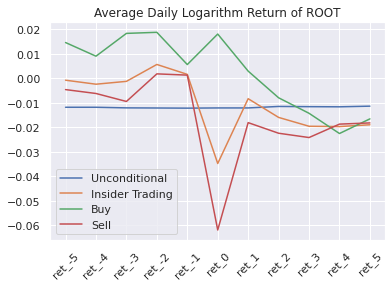

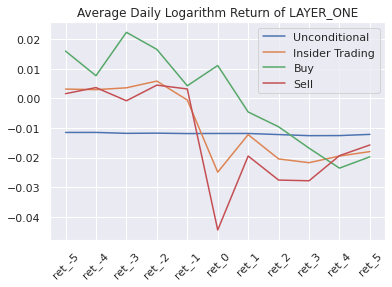

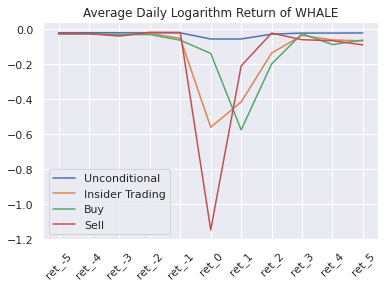

In [293]:
accs = ['root', 'layer_one', 'whale']
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret/lst/panel_insider.csv')
    df = df.loc[df[acc] == True]

    ret_mean = [df[i].mean() for i in ret_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].mean() for i in ret_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].mean() for i in ret_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].mean() for i in ret_info]

    fig, ax = plt.subplots()
    _ = ax.plot(ret_info, ret_mean, label='Unconditional')
    _ = ax.plot(ret_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(ret_info, buy_mean, label='Buy')
    _ = ax.plot(ret_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Average Daily Logarithm Return of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

### Daily Return Median

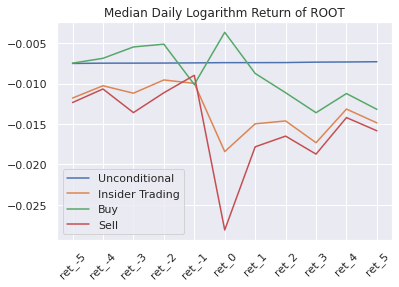

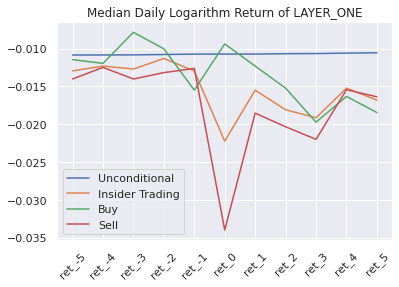

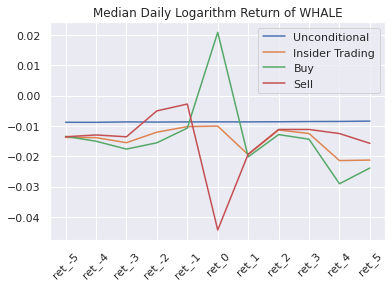

In [295]:
accs = ['root', 'layer_one', 'whale']
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret/lst/panel_insider.csv')
    df = df.loc[df[acc] == True]

    ret_mean = [df[i].median() for i in ret_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].median() for i in ret_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].median() for i in ret_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].median() for i in ret_info]

    fig, ax = plt.subplots()
    _ = ax.plot(ret_info, ret_mean, label='Unconditional')
    _ = ax.plot(ret_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(ret_info, buy_mean, label='Buy')
    _ = ax.plot(ret_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Median Daily Logarithm Return of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

### Cumulative Return

In [307]:
cumret_info = [f'cumret_{i}' for i in range(-5, 6)]

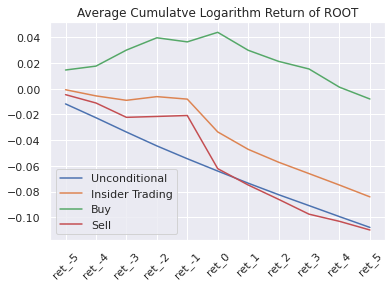

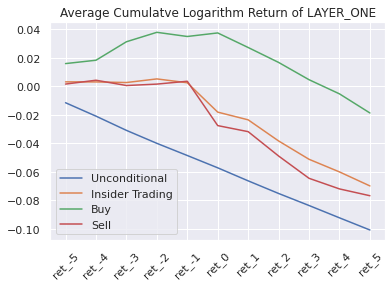

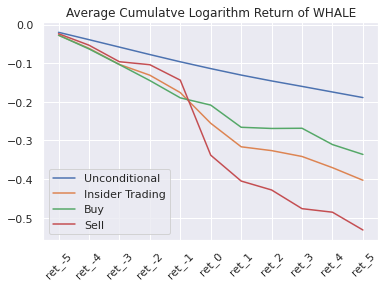

In [308]:
accs = ['root', 'layer_one', 'whale']
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret/lst/panel_insider.csv')
    df = df.loc[df[acc] == True]
    
    df['cumret_-5'] = df['ret_-5']
    df['cumret_-4'] = df['ret_-5'] + df['ret_-4']
    df['cumret_-3'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3']
    df['cumret_-2'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2']
    df['cumret_-1'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1']
    df['cumret_0'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0']
    df['cumret_1'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1']
    df['cumret_2'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1'] + df['ret_2']
    df['cumret_3'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1'] + df['ret_2'] + df['ret_3']
    df['cumret_4'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4']
    df['cumret_5'] = df['ret_-5'] + df['ret_-4'] + df['ret_-3'] + df['ret_-2'] + df['ret_-1'] + df['ret_0'] + df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4'] + df['ret_5']

    ret_mean = [df[i].mean() for i in cumret_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].mean() for i in cumret_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].mean() for i in cumret_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].mean() for i in cumret_info]

    fig, ax = plt.subplots()
    _ = ax.plot(ret_info, ret_mean, label='Unconditional')
    _ = ax.plot(ret_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(ret_info, buy_mean, label='Buy')
    _ = ax.plot(ret_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Average Cumulatve Logarithm Return of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    plt.legend()
    plt.show()

## Winning Probability of Insider Buy

In [70]:
winning_ret_info = [f'winning_ret_{i}' for i in range(1, 6)]
winpro_info = [f'winpro_{i}' for i in range(1, 6)]
cumwinpro_info = [f'cumwinpro_{i}' for i in range(1, 6)]

### PDF

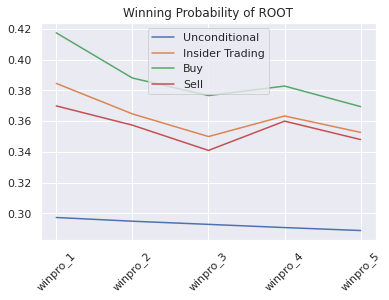

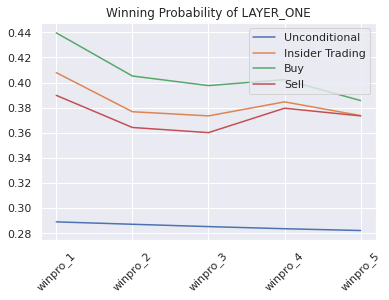

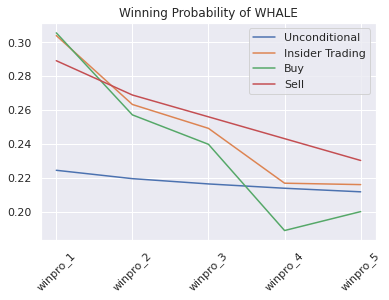

In [77]:
accs = ['root', 'layer_one', 'whale']
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret/lst/panel_insider.csv')
    df = df.loc[df[acc] == True]

    df['winpro_1'] = df['ret_1']>0
    df['winpro_2'] = df['ret_2']>0
    df['winpro_3'] = df['ret_3']>0
    df['winpro_4'] = df['ret_4']>0
    df['winpro_5'] = df['ret_5']>0
    
    ret_mean = [df[i].mean() for i in winpro_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].mean() for i in winpro_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].mean() for i in winpro_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].mean() for i in winpro_info]

    fig, ax = plt.subplots()
    _ = ax.plot(winpro_info, ret_mean, label='Unconditional')
    _ = ax.plot(winpro_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(winpro_info, buy_mean, label='Buy')
    _ = ax.plot(winpro_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Winning Probability of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

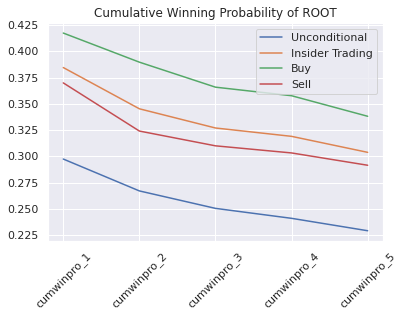

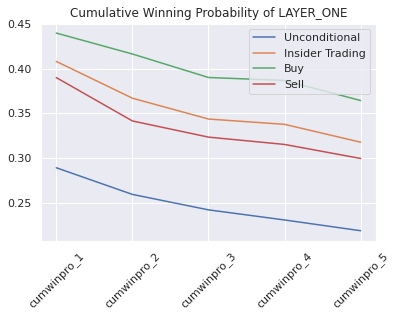

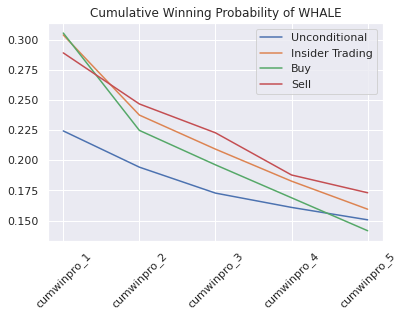

In [71]:
accs = ['root', 'layer_one', 'whale']
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret/lst/panel_insider.csv')
    df = df.loc[df[acc] == True]

    
    df['winning_ret_1'] = df['ret_1']
    df['winning_ret_2'] = df['ret_1'] + df['ret_2']
    df['winning_ret_3'] = df['ret_1'] + df['ret_2'] + df['ret_3']
    df['winning_ret_4'] = df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4']
    df['winning_ret_5'] = df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4'] + df['ret_5']
    
    df['cumwinpro_1'] = df['winning_ret_1']>0
    df['cumwinpro_2'] = df['winning_ret_2']>0
    df['cumwinpro_3'] = df['winning_ret_3']>0
    df['cumwinpro_4'] = df['winning_ret_4']>0
    df['cumwinpro_5'] = df['winning_ret_5']>0
    
    ret_mean = [df[i].mean() for i in cumwinpro_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].mean() for i in cumwinpro_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].mean() for i in cumwinpro_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].mean() for i in cumwinpro_info]

    fig, ax = plt.subplots()
    _ = ax.plot(cumwinpro_info, ret_mean, label='Unconditional')
    _ = ax.plot(cumwinpro_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(cumwinpro_info, buy_mean, label='Buy')
    _ = ax.plot(cumwinpro_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Cumulative Winning Probability of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

### Mean

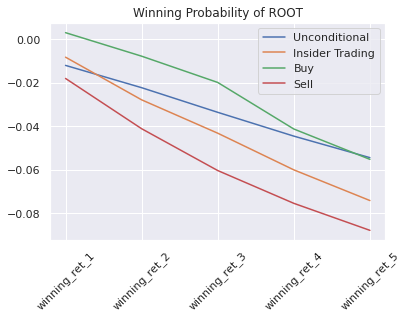

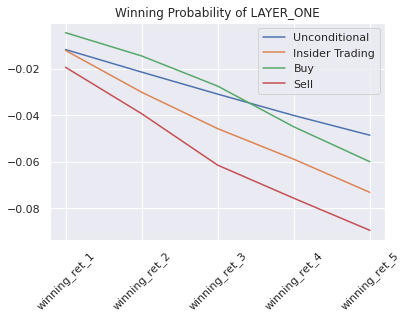

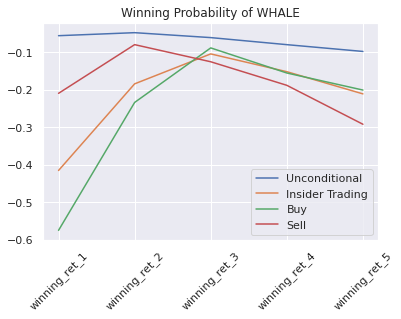

In [320]:
accs = ['root', 'layer_one', 'whale']
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret/lst/panel_insider.csv')
    df = df.loc[df[acc] == True]

    df['winning_ret_1'] = df['ret_1']
    df['winning_ret_2'] = df['ret_1'] + df['ret_2']
    df['winning_ret_3'] = df['ret_1'] + df['ret_2'] + df['ret_3']
    df['winning_ret_4'] = df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4']
    df['winning_ret_5'] = df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4'] + df['ret_5']
    
    ret_mean = [df[i].mean() for i in winning_ret_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].mean() for i in winning_ret_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].mean() for i in winning_ret_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].mean() for i in winning_ret_info]

    fig, ax = plt.subplots()
    _ = ax.plot(winning_ret_info, ret_mean, label='Unconditional')
    _ = ax.plot(winning_ret_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(winning_ret_info, buy_mean, label='Buy')
    _ = ax.plot(winning_ret_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Winning Probability of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

### Median

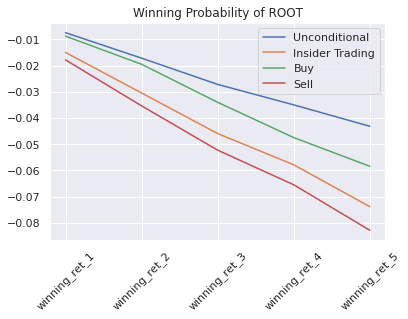

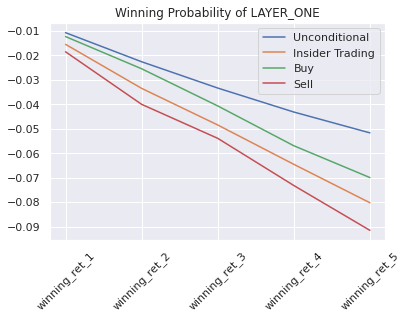

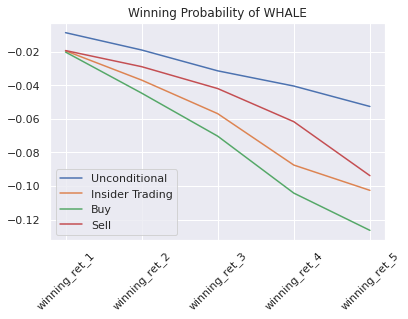

In [321]:
accs = ['root', 'layer_one', 'whale']
winning_ret_info = [f'winning_ret_{i}' for i in range(1, 6)]
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret/lst/panel_insider.csv')
    df = df.loc[df[acc] == True]

    df['winning_ret_1'] = df['ret_1']
    df['winning_ret_2'] = df['ret_1'] + df['ret_2']
    df['winning_ret_3'] = df['ret_1'] + df['ret_2'] + df['ret_3']
    df['winning_ret_4'] = df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4']
    df['winning_ret_5'] = df['ret_1'] + df['ret_2'] + df['ret_3'] + df['ret_4'] + df['ret_5']
    
    ret_mean = [df[i].median() for i in winning_ret_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].median() for i in winning_ret_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].median() for i in winning_ret_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].median() for i in winning_ret_info]

    fig, ax = plt.subplots()
    _ = ax.plot(winning_ret_info, ret_mean, label='Unconditional')
    _ = ax.plot(winning_ret_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(winning_ret_info, buy_mean, label='Buy')
    _ = ax.plot(winning_ret_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Winning Probability of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

## Event Probability

### Mean

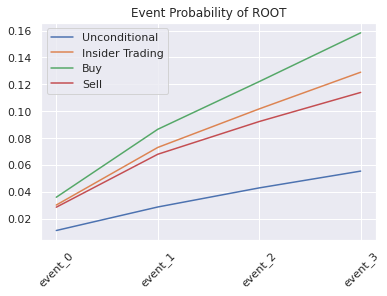

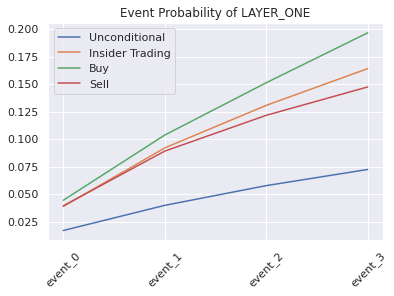

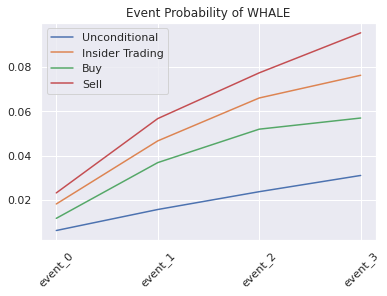

In [48]:
event_info = [f'event_{i}' for i in range(0, 4)]

accs = ['root', 'layer_one', 'whale']
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret/lst/panel_final.csv')
    df = df.loc[df[acc] == True]
    df = df.loc[df['twitter'] != 0]
    
    ret_mean = [df[i].mean() for i in event_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].mean() for i in event_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].mean() for i in event_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].mean() for i in event_info]

    fig, ax = plt.subplots()
    _ = ax.plot(event_info, ret_mean, label='Unconditional')
    _ = ax.plot(event_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(event_info, buy_mean, label='Buy')
    _ = ax.plot(event_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Event Probability of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

### Exact

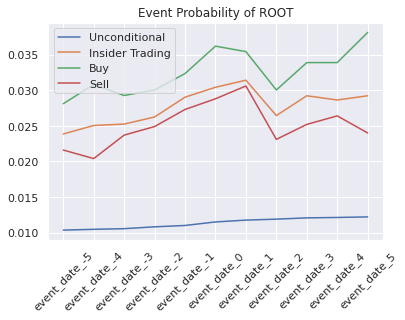

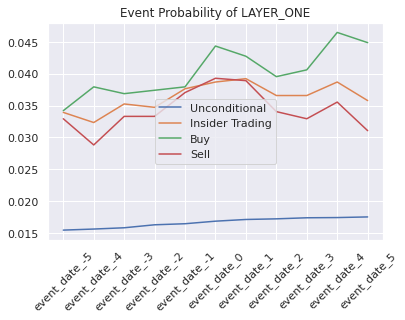

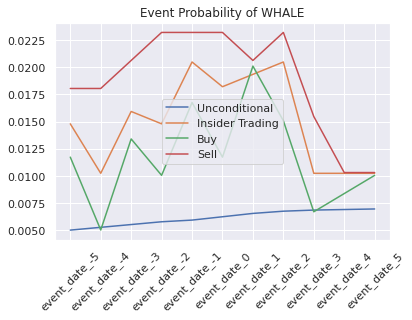

In [53]:
event_info = [f'event_date_{i}' for i in range(-5, 6)]

accs = ['root', 'layer_one', 'whale']
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret/lst/panel_end.csv')
    df = df.loc[df[acc] == True]
    df = df.loc[df['twitter'] != 0]
    
    ret_mean = [df[i].mean() for i in event_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].mean() for i in event_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].mean() for i in event_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].mean() for i in event_info]

    fig, ax = plt.subplots()
    _ = ax.plot(event_info, ret_mean, label='Unconditional')
    _ = ax.plot(event_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(event_info, buy_mean, label='Buy')
    _ = ax.plot(event_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Event Probability of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

# Insider Buy

## Buy and Sell Date

In [56]:
df = pd.read_csv(f'{WD}token_ret/lst/panel_insider.csv')

for idx, row in df[['contractAddress', 'chain']].drop_duplicates().iterrows():
    contractAddress = row['contractAddress']
    chain = row['chain']
    
    start_date = df.loc[(df['contractAddress'] == contractAddress)&(df['chain'] == chain), 'date'].min()
    end_date = df.loc[(df['contractAddress'] == contractAddress)&(df['chain'] == chain), 'date'].max()
    duration = (pd.to_datetime(end_date)-pd.to_datetime(start_date)).days
    df.loc[(df['contractAddress'] == contractAddress)&(df['chain'] == chain), 'start_date'] = start_date
    df.loc[(df['contractAddress'] == contractAddress)&(df['chain'] == chain), 'end_date'] = end_date
    df.loc[(df['contractAddress'] == contractAddress)&(df['chain'] == chain), 'duration'] = duration
    
df['scaled_progress'] = (pd.to_datetime(df['date']) - pd.to_datetime(df['start_date'])).dt.days / duration

df

,date,contractAddress,chain,ret_-5,ret_-4,ret_-3,ret_-2,ret_-1,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,priceUSD,root,layer_one,whale,insider_trading,insider_buy,insider_sell,start_date,end_date,duration,scaled_progress
0,2021-08-16,0x24e89bdf2f65326b94e36978a7edeac63623dafa,ethereum,NaN,NaN,NaN,NaN,NaN,NaN,-0.274647,-0.210052,0.139668,0.006935,-0.042418,0.000022,True,True,False,True,True,True,2021-08-16,2022-08-26,375.0,0.000
1,2021-08-17,0x24e89bdf2f65326b94e36978a7edeac63623dafa,ethereum,NaN,NaN,NaN,NaN,NaN,-0.274647,-0.210052,0.139668,0.006935,-0.042418,-0.023771,0.000017,True,True,False,True,True,True,2021-08-16,2022-08-26,375.0,0.008
2,2021-08-18,0x24e89bdf2f65326b94e36978a7edeac63623dafa,ethereum,NaN,NaN,NaN,NaN,-0.274647,-0.210052,0.139668,0.006935,-0.042418,-0.023771,0.053148,0.000014,True,True,False,True,True,True,2021-08-16,2022-08-26,375.0,0.016
3,2021-08-19,0x24e89bdf2f65326b94e36978a7edeac63623dafa,ethereum,NaN,NaN,NaN,-0.274647,-0.210052,0.139668,0.006935,-0.042418,-0.023771,0.053148,-0.004094,0.000016,True,True,False,False,False,False,2021-08-16,2022-08-26,375.0,0.024
4,2021-08-20,0x24e89bdf2f65326b94e36978a7edeac63623dafa,ethereum,NaN,NaN,-0.274647,-0.210052,0.139668,0.006935,-0.042418,-0.023771,0.053148,-0.004094,0.165303,0.000016,True,True,False,True,False,True,2021-08-16,2022-08-26,375.0,0.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135146,2022-07-17,0xE161C2e49B398253275Cd918fE620e3AdE1B61EA,avalanche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,2022-03-18,2022-07-21,125.0,0.968
135147,2022-07-18,0xE161C2e49B398253275Cd918fE620e3AdE1B61EA,avalanche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,2022-03-18,2022-07-21,125.0,0.976
135148,2022-07-19,0xE161C2e49B398253275Cd918fE620e3AdE1B61EA,avalanche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,2022-03-18,2022-07-21,125.0,0.984
135149,2022-07-20,0xE161C2e49B398253275Cd918fE620e3AdE1B61EA,avalanche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,2022-03-18,2022-07-21,125.0,0.992


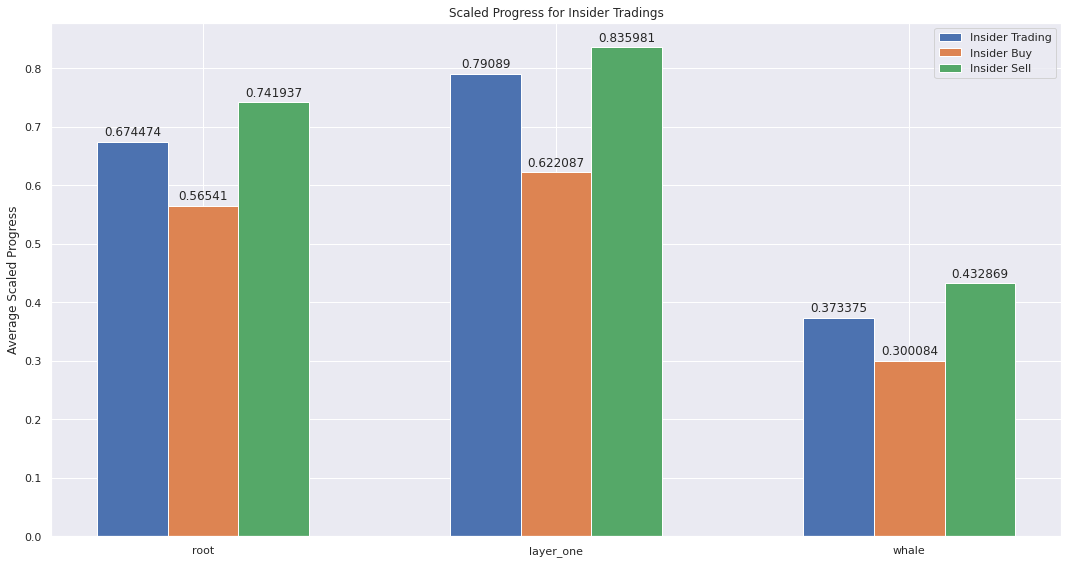

In [62]:
accs = ['root', 'layer_one', 'whale']
fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(accs))
width = 0.20
insider_trading_dates = []
insider_buy_dates = []
insider_sell_dates = []


for acc in accs:
    csv = df.loc[df[acc] == True].copy()
    insider_trading = csv.loc[csv['insider_trading'] == True].copy()
    insider_trading_date = insider_trading['scaled_progress'].mean()
    insider_trading_dates.append(insider_trading_date)
    
    insider_buy = csv.loc[csv['insider_buy'] == True].copy()
    insider_buy_date = insider_buy['scaled_progress'].mean()
    insider_buy_dates.append(insider_buy_date)
    
    insider_sell = csv.loc[csv['insider_sell'] == True].copy()
    insider_sell_date = insider_sell['scaled_progress'].mean()
    insider_sell_dates.append(insider_sell_date)
    

rects1 = ax.bar(x - width, insider_trading_dates, width, label='Insider Trading')
rects2 = ax.bar(x, insider_buy_dates, width, label='Insider Buy')
rects3 = ax.bar(x + width, insider_sell_dates, width, label='Insider Sell')

_ = ax.set_ylabel('Average Scaled Progress')
_ = ax.set_title('Scaled Progress for Insider Tradings')
_ = ax.set_xticks(x, accs)
_ = ax.legend()

_ = ax.bar_label(rects1, padding=3)
_ = ax.bar_label(rects2, padding=3)
_ = ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

## Example

### Root

In [164]:
df = pd.read_csv(f'{WD}token_ret/lst/panel_insider.csv')
df.loc[(df['chain'] == 'ethereum')&(df['root'] == True)].sample(3)

,date,contractAddress,chain,ret_-5,ret_-4,ret_-3,ret_-2,ret_-1,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,priceUSD,root,layer_one,whale,insider_trading,insider_buy,insider_sell
11050,2022-07-06,0xbf825207c74b6c3c01ab807c4f4a4fce26ebdf0f,ethereum,NaN,NaN,NaN,NaN,NaN,NaN,0.039361,0.037870,NaN,NaN,NaN,2.740000e-14,True,False,False,False,False,False
3431,2021-02-26,0xc944e90c64b2c07662a292be6244bdf05cda44a7,ethereum,-0.049571,-0.126065,-0.181849,0.12893,-0.094533,-0.008533,-0.033107,-0.055134,0.194063,-0.051865,0.084985,1.719461e+00,True,False,False,False,False,False
25723,2022-08-20,0x5c28dbdf5351089ca413b4493dd6c6043e44af42,ethereum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.035758,NaN,NaN,NaN,NaN,True,True,False,False,False,False


#### Graph

- Ethereum
- Only Swap

'uniswapv3_ethereum'

'uniswapv2_ethereum'

'2022-03-02'

'sushiswap_ethereum'

,Unnamed: 0,amountUSD,id,logIndex,origin,recipient,sender,sqrtPriceX96,tick,timestamp,token0_name,token1_name,token0_id,token1_id,transaction_id,amount0Out,amount0In,amount1Out,amount1In,home_token,dex,chain,insider_root,contractAddress,from,to,lp,buy,ret_1,ret_2,ret_3,ret_-1,ret_-2,ret_-3,date


,Unnamed: 0,amountUSD,id,logIndex,origin,recipient,sender,sqrtPriceX96,tick,timestamp,token0_name,token1_name,token0_id,token1_id,transaction_id,amount0Out,amount0In,amount1Out,amount1In,home_token,dex,chain,insider_root,contractAddress,from,to,lp,buy,ret_1,ret_2,ret_3,ret_-1,ret_-2,ret_-3,date
1734,1851,41.248415,0xfd277cabbfc425833b14d6514823a0611408c9c3ecf2967a7ba759861a25c14e-0,412,NaN,NaN,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,NaN,NaN,2022-03-03 03:09:46,Hirokage,Wrapped Ether,0x5c28dbdf5351089ca413b4493dd6c6043e44af42,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xfd277cabbfc425833b14d6514823a0611408c9c3ecf2967a7ba759861a25c14e,500000.0,0.0,0.0,0.014101,True,uniswapv2_ethereum,ethereum,0xfbc20e050048a885769a6da858ca726a22e44e9d,0x5c28dbdf5351089ca413b4493dd6c6043e44af42,0xfbc20e050048a885769a6da858ca726a22e44e9d,0xfbc20e050048a885769a6da858ca726a22e44e9d,False,41.248415,-0.173163,-0.172812,-0.261434,NaN,NaN,NaN,2022-03-03


,Unnamed: 0,amountUSD,id,logIndex,origin,recipient,sender,sqrtPriceX96,tick,timestamp,token0_name,token1_name,token0_id,token1_id,transaction_id,amount0Out,amount0In,amount1Out,amount1In,home_token,dex,chain,insider_root,contractAddress,from,to,lp,buy,ret_1,ret_2,ret_3,ret_-1,ret_-2,ret_-3,date


,Unnamed: 0,amountUSD,id,logIndex,origin,recipient,sender,sqrtPriceX96,tick,timestamp,token0_name,token1_name,token0_id,token1_id,transaction_id,amount0Out,amount0In,amount1Out,amount1In,home_token,dex,chain,insider_root,contractAddress,from,to,lp,buy,ret_1,ret_2,ret_3,ret_-1,ret_-2,ret_-3,date


,Unnamed: 0,amountUSD,id,logIndex,origin,recipient,sender,sqrtPriceX96,tick,timestamp,token0_name,token1_name,token0_id,token1_id,transaction_id,amount0Out,amount0In,amount1Out,amount1In,home_token,dex,chain,insider_root,contractAddress,from,to,lp,buy,ret_1,ret_2,ret_3,ret_-1,ret_-2,ret_-3,date


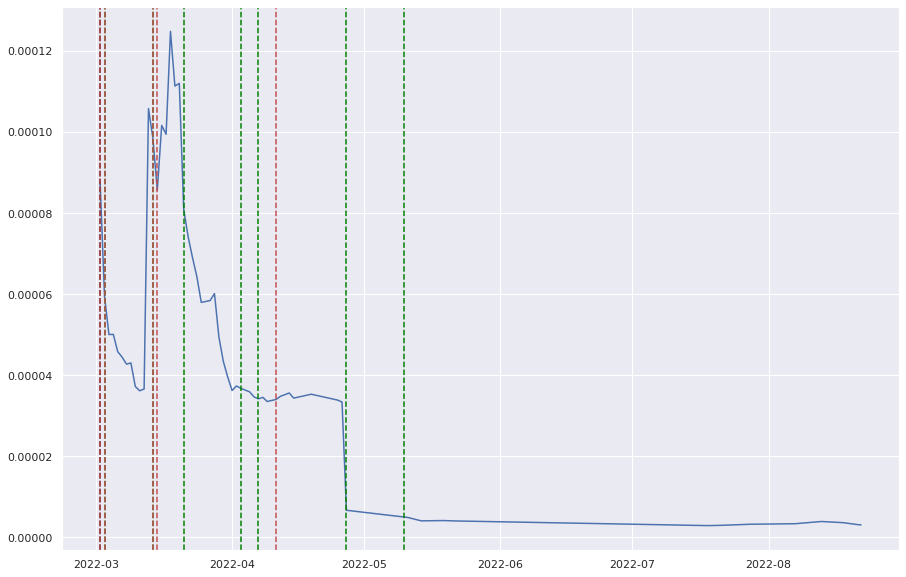

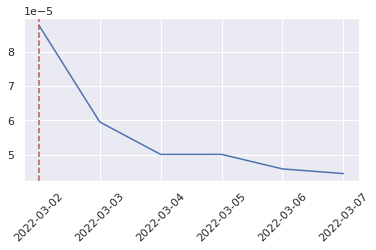

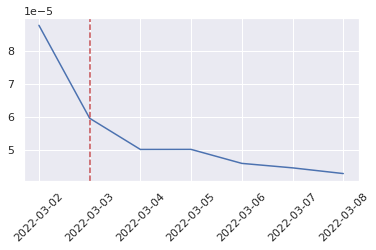

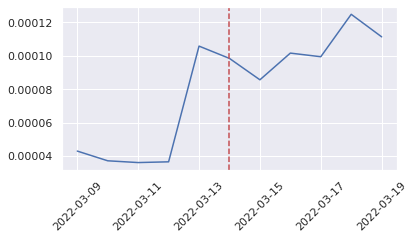

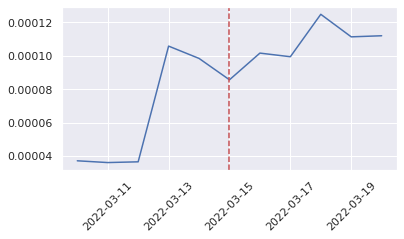

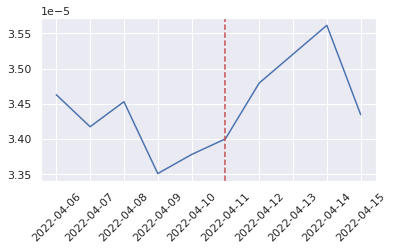

,date,contractAddress,chain,ret_-5,ret_-4,ret_-3,ret_-2,ret_-1,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,priceUSD,root,layer_one,whale,insider_trading,insider_buy,insider_sell
25592,2022-04-11,0x5c28dbdf5351089ca413b4493dd6c6043e44af42,ethereum,-0.035612,-0.013225,0.010355,-0.029985,0.00803,0.006563,0.023032,NaN,NaN,-0.036227,NaN,0.000034,True,True,False,True,True,False


In [167]:
contract = '0x5c28dbdf5351089ca413b4493dd6c6043e44af42'
chain = 'ethereum'
lst = 'root'
contractAddress_lower = contract.lower()
contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)
dex_num = 0

dfs = pd.read_csv(f'{RES}/transaction/{lst}.csv')
dfs['timestamp'] = pd.to_datetime(dfs['timestamp'])
dfs['date'] = dfs['timestamp'].dt.strftime('%Y-%m-%d')
if lst != 'root': dfs.rename(columns={'insider_contractAddress':'contractAddress'}, inplace=True)

panel = []
dex_dates = []
for dex in chain_info(chain):
    dex
    lst = pd.read_csv(f'{WD}/dex_price/list_all/{dex}.csv')
    csv_info = lst.loc[((lst['contractAddress'] == contractAddress_lower)|
                        (lst['contractAddress'] == contractAddress_upper))]

    if csv_info['contractAddress'].values[0] == contractAddress_lower:
        contractAddress = contractAddress_lower
    else:
        contractAddress = contractAddress_upper

    status = csv_info['status'].values[0]
    dexn = csv_info['dex'].values[0]

    if status == 0: 
        continue
    elif dexn == 0:
        continue
    else:
        csv = pd.read_csv(f'{WD}dex_price/csv_all/{contractAddress}_{dex}.csv') 
        csv = csv.loc[:, ['priceUSD', 'date']]
        csv['date'].min()
        dex_dates.append(csv['date'].min())       
        panel.append(csv)
        dex_num += 1

if dex_num != 0:
    panel = pd.concat(panel)
    panel = panel.loc[panel['priceUSD']!=0]

start_date = panel['date'].min()

avg = panel.groupby('date')['priceUSD'].mean().reset_index()
avg.sort_values('date', ascending=True, inplace=True)


fig, ax = plt.subplots(figsize=(15, 10))
_ = ax.plot(pd.to_datetime(avg['date'].values), avg['priceUSD'].values)

for dex_date in dex_dates:
    _ = ax.axvline(pd.to_datetime(dex_date), linestyle='--', color='black')

for sell_date in df.loc[(df['contractAddress'] == contract)&(df['root'] == True)&(df['insider_sell'] == True), 'date']:
    _ = ax.axvline(pd.to_datetime(sell_date), linestyle='--', color='green')   
    
for buy_date in df.loc[(df['contractAddress'] == contract)&(df['root'] == True)&(df['insider_buy'] == True), 'date']:
    _ = ax.axvline(pd.to_datetime(buy_date), linestyle='--', color='r')   
    
    fig, bx = plt.subplots(figsize=(6, 3))
    buy_info = avg.loc[(pd.to_datetime(avg['date']) <= pd.to_datetime(buy_date)+datetime.timedelta(days=5))&
                       (pd.to_datetime(avg['date']) >= pd.to_datetime(buy_date)-datetime.timedelta(days=5))]
    _ = bx.plot(pd.to_datetime(buy_info['date'].values), buy_info['priceUSD'].values)
    _ = bx.axvline(pd.to_datetime(buy_date), linestyle='--', color='r')   
    _ = plt.xticks(rotation=45)
    
    dfs.loc[(dfs['contractAddress'] == contract)&(dfs['date'] == buy_date)&(dfs['chain'] == chain)]


plt.show()

df.loc[(df['contractAddress'] == contract)&(df['date'] == buy_date)&(df['chain'] == chain)]

# Crashes

## Projects

'root'

144

604

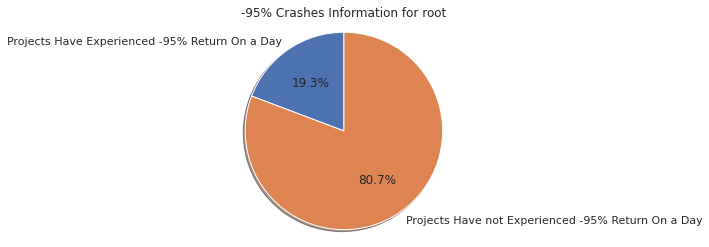

'layer_one'

48

118

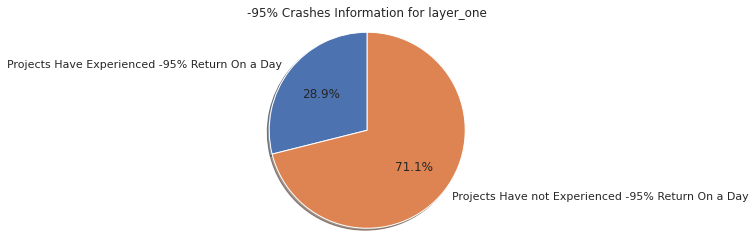

'whale'

66

413

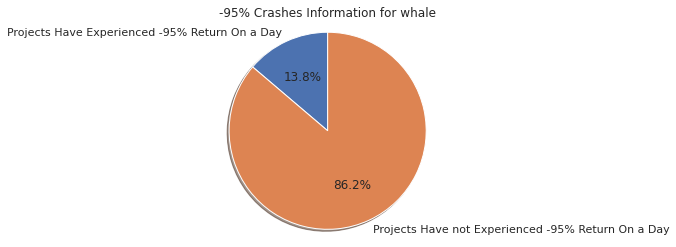

<AxesSubplot:xlabel='date'>

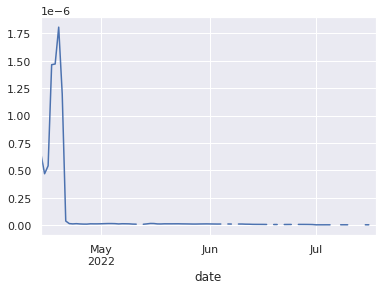

In [111]:
for acc in accs:
    acc
    crash = []
    
    have = df.loc[(df['ret_0'] <= -0.95)&(df[acc]==True), ['contractAddress','chain']].drop_duplicates().shape[0]
    total = df.loc[df[acc]==True,['contractAddress','chain']].drop_duplicates().shape[0]
    havenot = total - have
    
    have
    havenot
    
    crash.append(have)
    crash.append(havenot)
    

    labels = 'Projects Have Experienced -95% Return On a Day', 'Projects Have not Experienced -95% Return On a Day'

    fig1, ax1 = plt.subplots()
    _ = ax1.pie(crash, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
    _ = ax1.set_title(f'-95% Crashes Information for {acc}')
    _ = ax1.axis('equal')

    plt.show()

contractAddress = df.loc[df['ret_0'] <= -0.95, ['contractAddress']].sample(1)['contractAddress'].values[0]
df['date'] = pd.to_datetime(df['date'])
df.loc[df['contractAddress'] == contractAddress].set_index('date')['priceUSD'].plot()

## Insider Sell

In [153]:
crash_info = [f'crash_sell_{i}' for i in range(-5,6)]

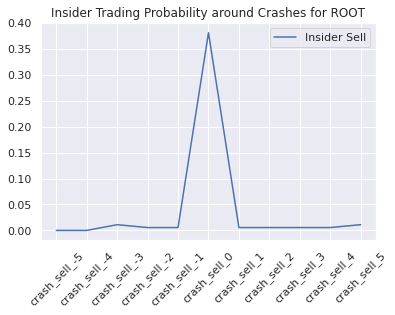

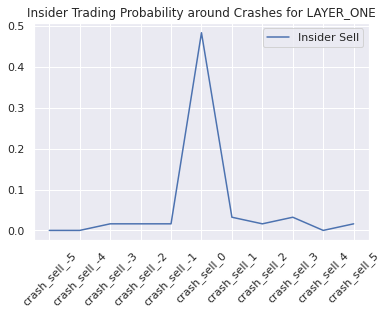

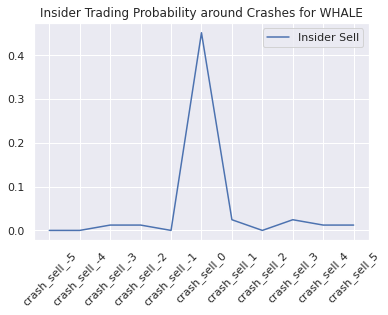

In [161]:
for acc in accs:
    cra = df.loc[(df['ret_0'] <= -0.95)&(df[acc]==True)]
    cra['date'] = pd.to_datetime(cra['date'])
    for i in range(-5, 6):
        cra[f'crash_sell_{i}'] = 0
        
    for idx, row in cra.iterrows():
        date = row['date']
        contractAddress = row['contractAddress']
        chain = row['chain']
        
        for i in range(-5, 6):
            if cra.loc[(cra['contractAddress'] == contractAddress)&
                       (cra['chain'] == chain)&
                       (cra['date'] == date - datetime.timedelta(days=i)), 'insider_sell'].values == True:

                   cra.loc[(cra['contractAddress'] == contractAddress)&
                           (cra['chain'] == chain)&
                           (cra['date'] == date), f'crash_sell_{i}'] = 1
                    
#     uncon = []
#     for idx, row in df.loc[(df['ret_0'] <= -0.95)&(df[acc]==True), ['contractAddress','chain']].drop_duplicates().iterrows():
#         contractAddress = row['contractAddress']
#         chain = row['chain']
#         uncon.append(df.loc[(df['contractAddress'] == contractAddress)&
#                     (df['chain'] == chain)])
        
#     uncon = pd.concat(uncon)
#     uncon['date'] = pd.to_datetime(uncon['date'])
#     for idx, row in uncon.iterrows():
#         date = row['date']
#         contractAddress = row['contractAddress']
#         chain = row['chain']
#         for i in range(-5, 6):
#             if uncon.loc[(uncon['contractAddress'] == contractAddress)&
#                          (uncon['chain'] == chain)&
#                          (uncon['date'] == date - datetime.timedelta(days=i)), 'insider_sell'].values == True:

#                    uncon.loc[(uncon['contractAddress'] == contractAddress)&
#                            (uncon['chain'] == chain)&
#                            (uncon['date'] == date), f'crash_sell_{i}'] = 1
    
    
    cra_mean = [cra[i].mean() for i in crash_info]
    # uncon_mean = [uncon[i].mean() for i in crash_info]

    fig, ax = plt.subplots()
    # _ = ax.plot(crash_info, uncon_mean, label='Unconditional')
    _ = ax.plot(crash_info, cra_mean, label='Insider Sell')
    _ = ax.set_title(f'Insider Trading Probability around Crashes for {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()

# Variable: Crash

In [176]:
crash_info = [f'crash_{i}' for i in range(-5,6)]

In [177]:
df = pd.read_csv(f'{WD}token_ret/lst/panel_insider.csv')
df['date'] = pd.to_datetime(df['date'])
total = df.shape[0]
done = 0

for i in range(-5, 6):
    df[f'crash_{i}'] = 0

for idx, row in df.iterrows():
    done += 1
    date = row['date']
    contractAddress = row['contractAddress']
    chain = row['chain']

    for i in range(-5, 6):
        if df.loc[(df['contractAddress'] == contractAddress)&
                   (df['chain'] == chain)&
                   (df['date'] == date - datetime.timedelta(days=i)), 'ret_0'].values <= -0.95:

               df.loc[(df['contractAddress'] == contractAddress)&
                       (df['chain'] == chain)&
                       (df['date'] == date), f'crash_{i}'] = 1
    
    print(f'{done}/{total}')

df

1/135151
2/135151
3/135151
4/135151
5/135151
6/135151
7/135151
8/135151
9/135151
10/135151
11/135151
12/135151
13/135151
14/135151
15/135151
16/135151
17/135151
18/135151
19/135151
20/135151
21/135151
22/135151
23/135151
24/135151
25/135151
26/135151
27/135151
28/135151
29/135151
30/135151
31/135151
32/135151
33/135151
34/135151
35/135151
36/135151
37/135151
38/135151
39/135151
40/135151
41/135151
42/135151
43/135151
44/135151
45/135151
46/135151
47/135151
48/135151
49/135151
50/135151
51/135151
52/135151
53/135151
54/135151
55/135151
56/135151
57/135151
58/135151
59/135151
60/135151
61/135151
62/135151
63/135151
64/135151
65/135151
66/135151
67/135151
68/135151
69/135151
70/135151
71/135151
72/135151
73/135151
74/135151
75/135151
76/135151
77/135151
78/135151
79/135151
80/135151
81/135151
82/135151
83/135151
84/135151
85/135151
86/135151
87/135151
88/135151
89/135151
90/135151
91/135151
92/135151
93/135151
94/135151
95/135151
96/135151
97/135151
98/135151
99/135151
100/135151
101/1351

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



50119/135151
50120/135151
50121/135151
50122/135151
50123/135151
50124/135151
50125/135151
50126/135151
50127/135151
50128/135151
50129/135151
50130/135151
50131/135151
50132/135151
50133/135151
50134/135151
50135/135151
50136/135151
50137/135151
50138/135151
50139/135151
50140/135151
50141/135151
50142/135151
50143/135151
50144/135151
50145/135151
50146/135151
50147/135151
50148/135151
50149/135151
50150/135151
50151/135151
50152/135151
50153/135151
50154/135151
50155/135151
50156/135151
50157/135151
50158/135151
50159/135151
50160/135151
50161/135151
50162/135151
50163/135151
50164/135151
50165/135151
50166/135151
50167/135151
50168/135151
50169/135151
50170/135151
50171/135151
50172/135151
50173/135151
50174/135151
50175/135151
50176/135151
50177/135151
50178/135151
50179/135151
50180/135151
50181/135151
50182/135151
50183/135151
50184/135151
50185/135151
50186/135151
50187/135151
50188/135151
50189/135151
50190/135151
50191/135151
50192/135151
50193/135151
50194/135151
50195/135151

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



80056/135151
80057/135151
80058/135151
80059/135151
80060/135151
80061/135151
80062/135151
80063/135151
80064/135151
80065/135151
80066/135151
80067/135151
80068/135151
80069/135151
80070/135151
80071/135151
80072/135151
80073/135151
80074/135151
80075/135151
80076/135151
80077/135151
80078/135151
80079/135151
80080/135151
80081/135151
80082/135151
80083/135151
80084/135151
80085/135151
80086/135151
80087/135151
80088/135151
80089/135151
80090/135151
80091/135151
80092/135151
80093/135151
80094/135151
80095/135151
80096/135151
80097/135151
80098/135151
80099/135151
80100/135151
80101/135151
80102/135151
80103/135151
80104/135151
80105/135151
80106/135151
80107/135151
80108/135151
80109/135151
80110/135151
80111/135151
80112/135151
80113/135151
80114/135151
80115/135151
80116/135151
80117/135151
80118/135151
80119/135151
80120/135151
80121/135151
80122/135151
80123/135151
80124/135151
80125/135151
80126/135151
80127/135151
80128/135151
80129/135151
80130/135151
80131/135151
80132/135151

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



99283/135151
99284/135151
99285/135151
99286/135151
99287/135151
99288/135151
99289/135151
99290/135151
99291/135151
99292/135151
99293/135151
99294/135151
99295/135151
99296/135151
99297/135151
99298/135151
99299/135151
99300/135151
99301/135151
99302/135151
99303/135151
99304/135151
99305/135151
99306/135151
99307/135151
99308/135151
99309/135151
99310/135151
99311/135151
99312/135151
99313/135151
99314/135151
99315/135151
99316/135151
99317/135151
99318/135151
99319/135151
99320/135151
99321/135151
99322/135151
99323/135151
99324/135151
99325/135151
99326/135151
99327/135151
99328/135151
99329/135151
99330/135151
99331/135151
99332/135151
99333/135151
99334/135151
99335/135151
99336/135151
99337/135151
99338/135151
99339/135151
99340/135151
99341/135151
99342/135151
99343/135151
99344/135151
99345/135151
99346/135151
99347/135151
99348/135151
99349/135151
99350/135151
99351/135151
99352/135151
99353/135151
99354/135151
99355/135151
99356/135151
99357/135151
99358/135151
99359/135151

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [178]:
df.to_csv(f'{WD}token_ret/lst/panel_crash.csv')

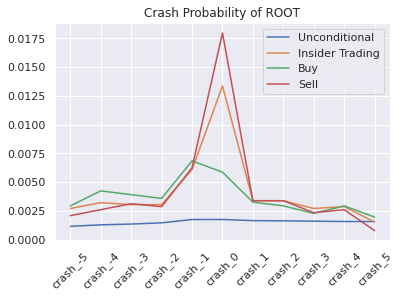

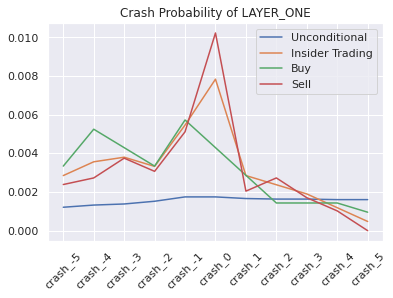

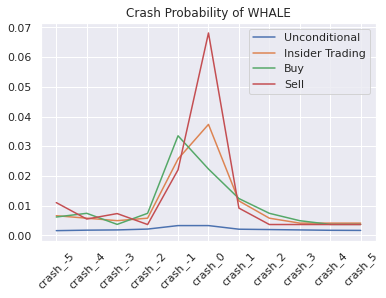

In [179]:
accs = ['root', 'layer_one', 'whale']
for acc in accs:
    df = pd.read_csv(f'{WD}token_ret/lst/panel_crash.csv')
    df = df.loc[df[acc] == True]
    
    ret_mean = [df[i].mean() for i in crash_info]

    insider_trading = df.loc[df['insider_trading'] == True].copy()
    insider_trading_mean = [insider_trading[i].mean() for i in crash_info]

    buy = df.loc[df['insider_buy'] == True].copy()
    buy_mean = [buy[i].mean() for i in crash_info]

    sell = df.loc[df['insider_sell'] == True].copy()
    sell_mean = [sell[i].mean() for i in crash_info]

    fig, ax = plt.subplots()
    _ = ax.plot(crash_info, ret_mean, label='Unconditional')
    _ = ax.plot(crash_info, insider_trading_mean, label='Insider Trading')
    _ = ax.plot(crash_info, buy_mean, label='Buy')
    _ = ax.plot(crash_info, sell_mean, label='Sell')
    _ = ax.set_title(f'Crash Probability of {acc.upper()}')

    _ = plt.xticks(rotation=45)
    _ = plt.legend()
    plt.show()